In [1]:
import os
import joblib
from itertools import combinations
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import is_numeric_dtype
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.ticker import PercentFormatter
import shap

We are refining the main dataset to meet a clear business goal: to create a model that predicts a student's final academic outcome. To do this effectively, the model must be trained on data with confirmed historical outcomes. Records of students who are still "Enrolled" represent an uncertain, ongoing status rather than a final outcome. Including this ambiguity would introduce noise and compromise the model's ability to learn the distinct patterns that differentiate students who eventually graduate from those who drop out.

The exported file containing the "enrolled" students is preserved for the main application of the model. Once our model is trained and validated on historical data, we will use it to predict future outcomes for this group of "enrolled" students. This allows us to generate a dropout risk score for each currently active student, enabling the institution to proactively identify individuals at risk and implement targeted interventions to improve retention.

In [2]:
df = pd.read_csv('./data/dataset.csv')

enrolled_df = df[df['Target'] == 'Enrolled'].copy()
enrolled_df.to_csv('./data/enrolled_students.csv', index=False)

df = df[df['Target'] != 'Enrolled']

cols_to_convert_to_category = [
    'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
    'Previous qualification', 'Nacionality', "Mother's qualification", 
    "Father's qualification", "Mother's occupation", "Father's occupation", 
    'Displaced', 'Educational special needs', 'Debtor', "Target",
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

for col in cols_to_convert_to_category:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  3630 non-null   category
 1   Application mode                                3630 non-null   category
 2   Application order                               3630 non-null   int64   
 3   Course                                          3630 non-null   category
 4   Daytime/evening attendance                      3630 non-null   category
 5   Previous qualification                          3630 non-null   category
 6   Nacionality                                     3630 non-null   category
 7   Mother's qualification                          3630 non-null   category
 8   Father's qualification                          3630 non-null   category
 9   Mother's occupation                

In [4]:
df.describe()

,Application order,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,1.750138,23.461157,0.754270,6.337466,8.071074,4.791460,10.534860,0.128926,0.581818,6.296419,7.763085,4.518457,10.036155,0.142149,11.630358,1.231598,-0.009256
std,1.333831,7.827994,2.477277,2.570773,4.286632,3.237845,5.057694,0.679111,2.022688,2.263020,3.964163,3.162376,5.481742,0.747670,2.667652,1.384911,2.259986
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.517857,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,20.000000,0.000000,6.000000,8.000000,5.000000,12.341429,0.000000,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,1.400000,0.320000
75%,2.000000,25.000000,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000
max,6.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


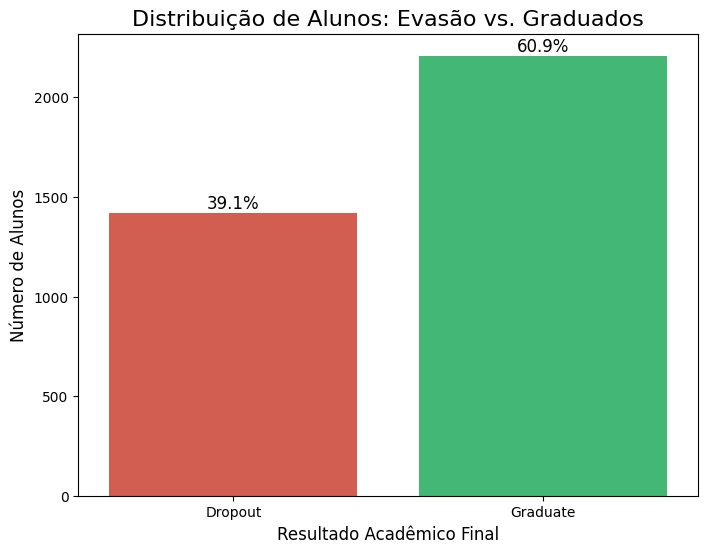

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Target', data=df, palette=['#E74C3C', '#2ECC71'])

plt.title('Student Distribution: Dropout vs. Graduated', fontsize=16)
plt.xlabel('Final Academic Outcome', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)

total = len(df['Target'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

This chart shows the exact proportion between dropouts and graduations. The classes are highly imbalanced (e.g., 60.9% graduates and 39.1% dropouts), so it may be necessary to use sampling techniques (such as SMOTE or ADASYN), specific evaluation metrics (such as F1-Score), and class weighting during modeling.


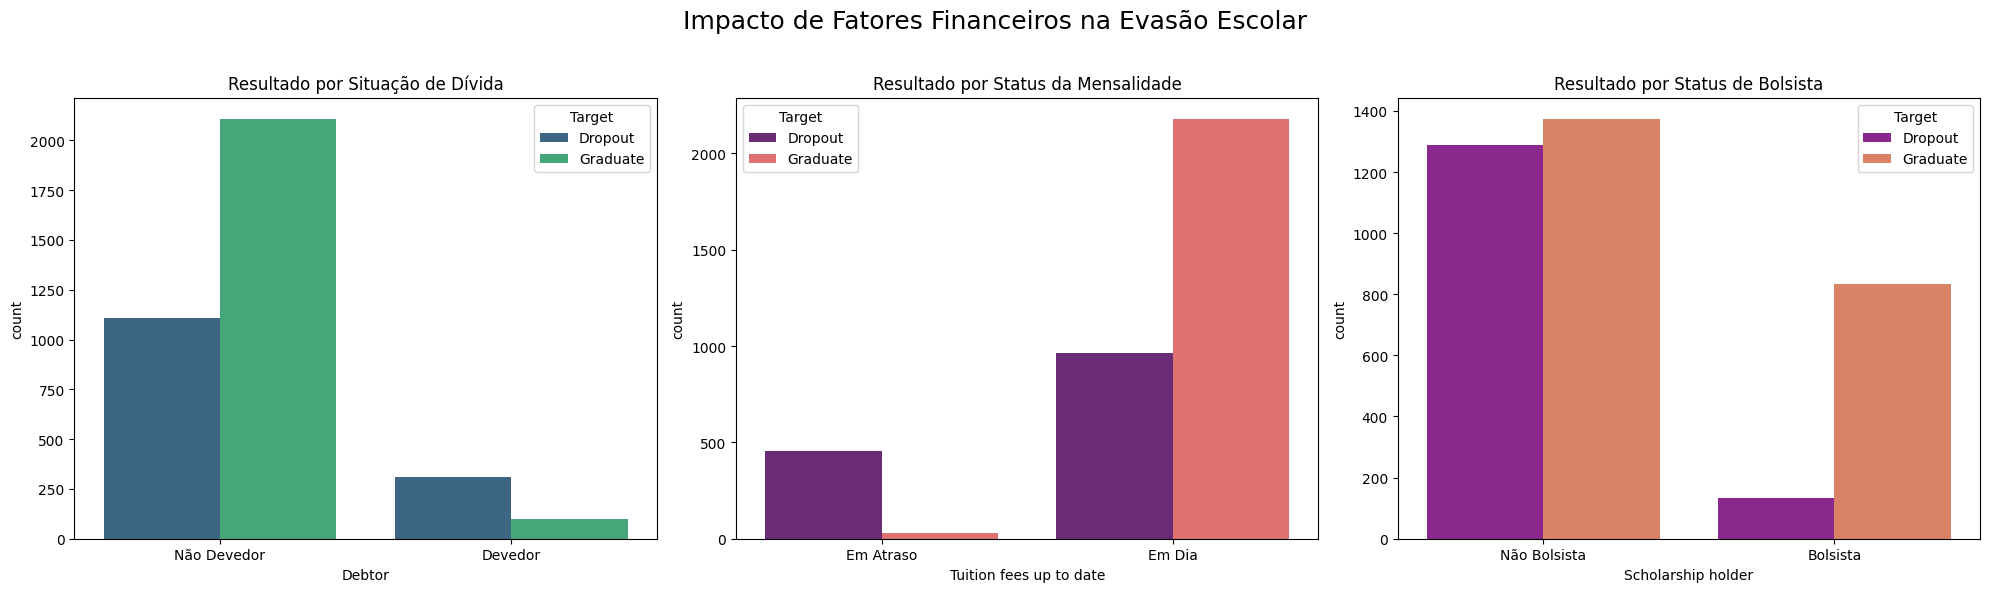

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Impact of Financial Factors on School Dropout', fontsize=18)

sns.countplot(ax=axes[0], x='Debtor', hue='Target', data=df, palette='viridis')
axes[0].set_title('Outcome by Debt Status')
axes[0].set_xticklabels(['Not in Debt', 'In Debt'])

sns.countplot(ax=axes[1], x='Tuition fees up to date', hue='Target', data=df, palette='magma')
axes[1].set_title('Outcome by Tuition Payment Status')
axes[1].set_xticklabels(['Overdue', 'Up to Date'])

sns.countplot(ax=axes[2], x='Scholarship holder', hue='Target', data=df, palette='plasma')
axes[2].set_title('Outcome by Scholarship Status')
axes[2].set_xticklabels(['Non-Scholarship', 'Scholarship'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The charts show that having debts or overdue tuition payments is strongly correlated with dropout. On the other hand, being a scholarship recipient tends to be associated with a higher graduation rate, possibly by reducing financial pressure and selecting high-performing students.


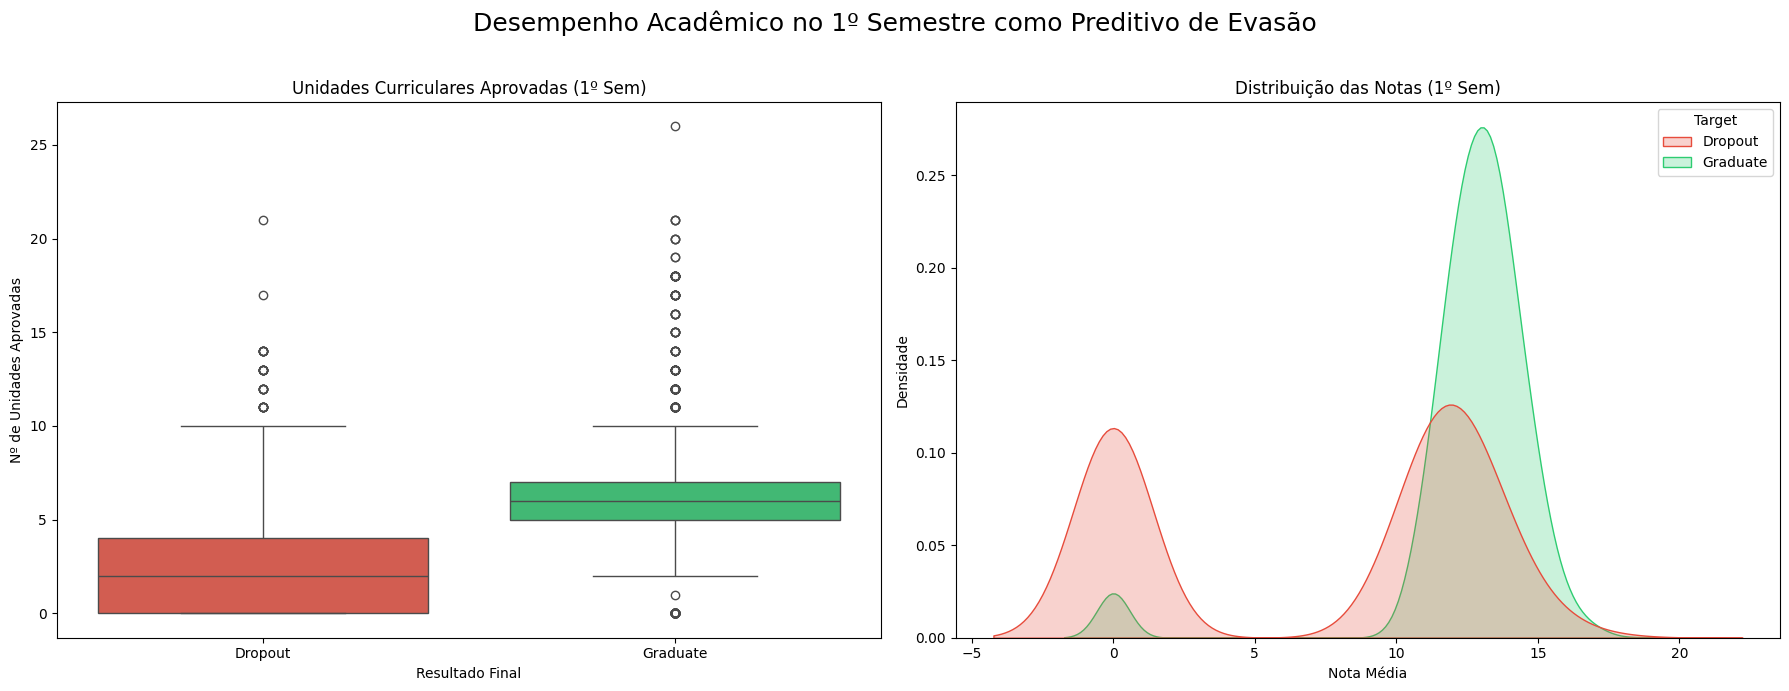

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Academic Performance in 1st Semester as a Predictor of Dropout', fontsize=18)

sns.boxplot(ax=axes[0], x='Target', y='Curricular units 1st sem (approved)', data=df, palette=['#E74C3C', '#2ECC71'])
axes[0].set_title('Approved Curricular Units (1st Sem)')
axes[0].set_xlabel('Final Outcome')
axes[0].set_ylabel('Number of Approved Units')

sns.kdeplot(data=df, x='Curricular units 1st sem (grade)', hue='Target',
            fill=True, common_norm=False, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Grade Distribution (1st Sem)')
axes[1].set_xlabel('Average Grade')
axes[1].set_ylabel('Density')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

It becomes evident that students who pass more subjects and have higher grades in the very first semester have a much higher chance of graduating. A low number of passed subjects is a strong early warning sign for dropout.

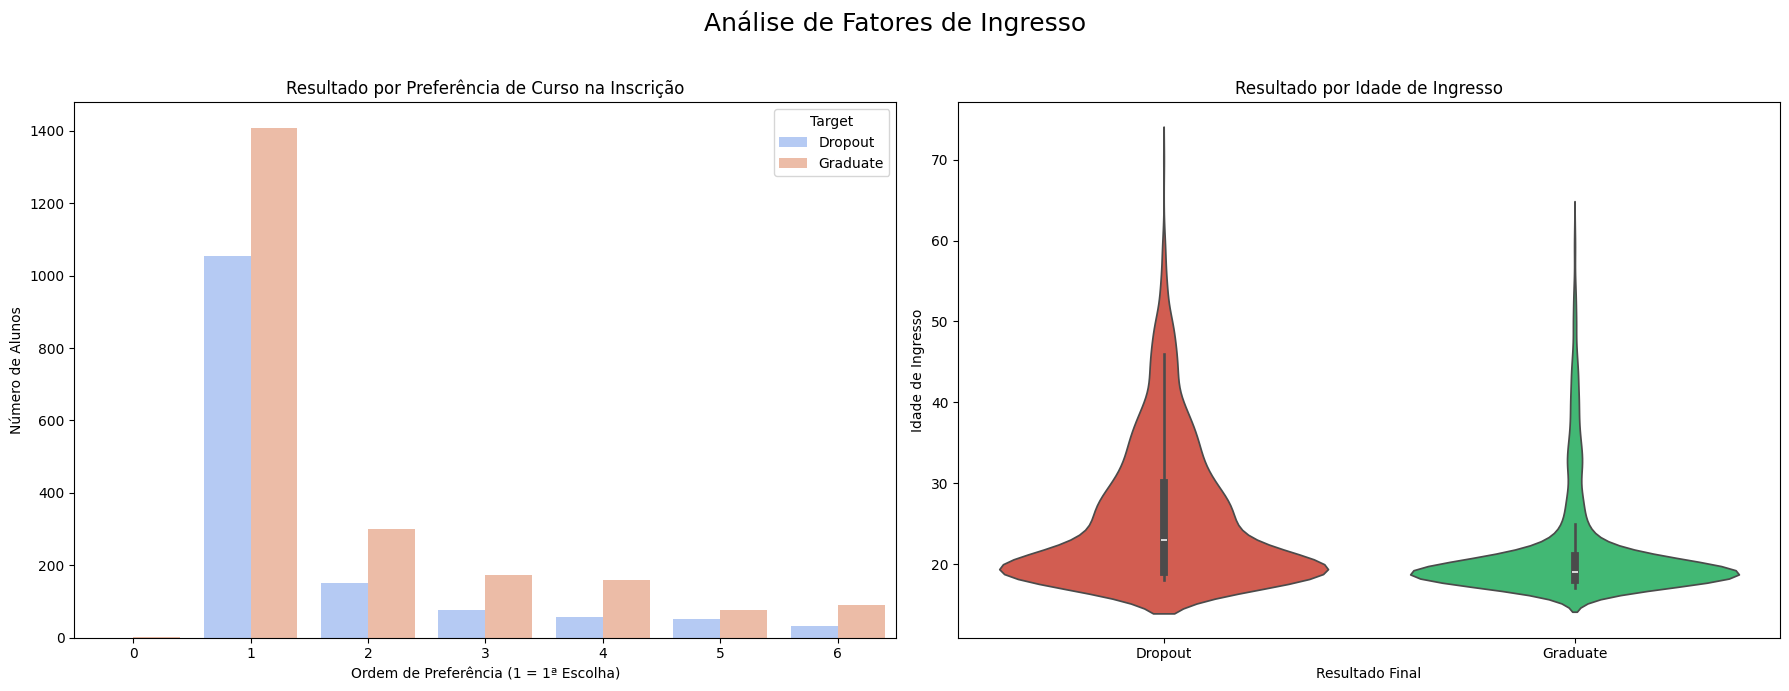

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Analysis of Admission Factors', fontsize=18)

sns.countplot(ax=axes[0], x='Application order', hue='Target', data=df, palette='coolwarm')
axes[0].set_title('Outcome by Course Preference in Application')
axes[0].set_xlabel('Preference Order (1 = 1st Choice)')
axes[0].set_ylabel('Number of Students')

sns.violinplot(ax=axes[1], x='Target', y='Age at enrollment', data=df, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Outcome by Age at Enrollment')
axes[1].set_xlabel('Final Outcome')
axes[1].set_ylabel('Age at Enrollment')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Students who enter the course as their first choice (Application order = 1) intuitively tend to be more motivated and, consequently, have a lower dropout rate, but the chart above shows us that the proportion of graduates and dropouts remains the same as the Preference Order increases. Age analysis may reveal that older students (mature students) have slightly higher dropout rates, possibly because they have to balance work, study, family, and other responsibilities that come with being older.

## Statistical Analysis

| Variable Type 1 | Variable Type 2 | Recommended Test | Notes |
| :--- | :--- | :--- | :--- |
| Categorical | Categorical | Chi-square test | Tests independence between categories |
| Numerical | Numerical | Pearson correlation (or Spearman for non-parametric) | Measures strength and direction of linear relationship |
| Categorical | Numerical | ANOVA (or t-test for 2 groups) | Tests difference of numerical means between categorical groups |
| Numerical | Categorical | ANOVA (same situation as above, just reversed) | The test is symmetrical in this case |
| Categorical (target) | Numerical | Classification models (e.g., logistic regression) and specific tests | ANOVA is not recommended for association with categorical target |
| Numerical (target) | Categorical | ANOVA (compare means between groups of the categorical) | Classic case for ANOVA |


### Pearson Correlation Matrix (Between Numerical Variables)

It is a table that shows the degree of linear association between pairs of numerical variables.

It uses the Pearson correlation coefficient (r) to measure how much two variables move together, that is, how increases or decreases in one variable are associated with increases or decreases in another.


| r Value | Interpretation |
| :--- | :--- |
| +1 | Perfect positive linear correlation |
| 0 | No linear correlation |
| -1 | Perfect negative linear correlation |

**Important**: Pearson only measures linear relationships. Two variables can be non-linearly dependent and still have r ≈ 0.


For two variables X and Y with n observations, the Pearson correlation coefficient r is calculated as:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}
         {\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \cdot \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

Where:
- $X_i$ and $Y_i$ are the individual values of variables $X$ and $Y$
- $\bar{X}$ and $\bar{Y}$ are the means of variables $X$ and $Y$
- The numerator is the covariance between $X$ and $Y$
- The denominator is the product of the standard deviations of $X$ and $Y$


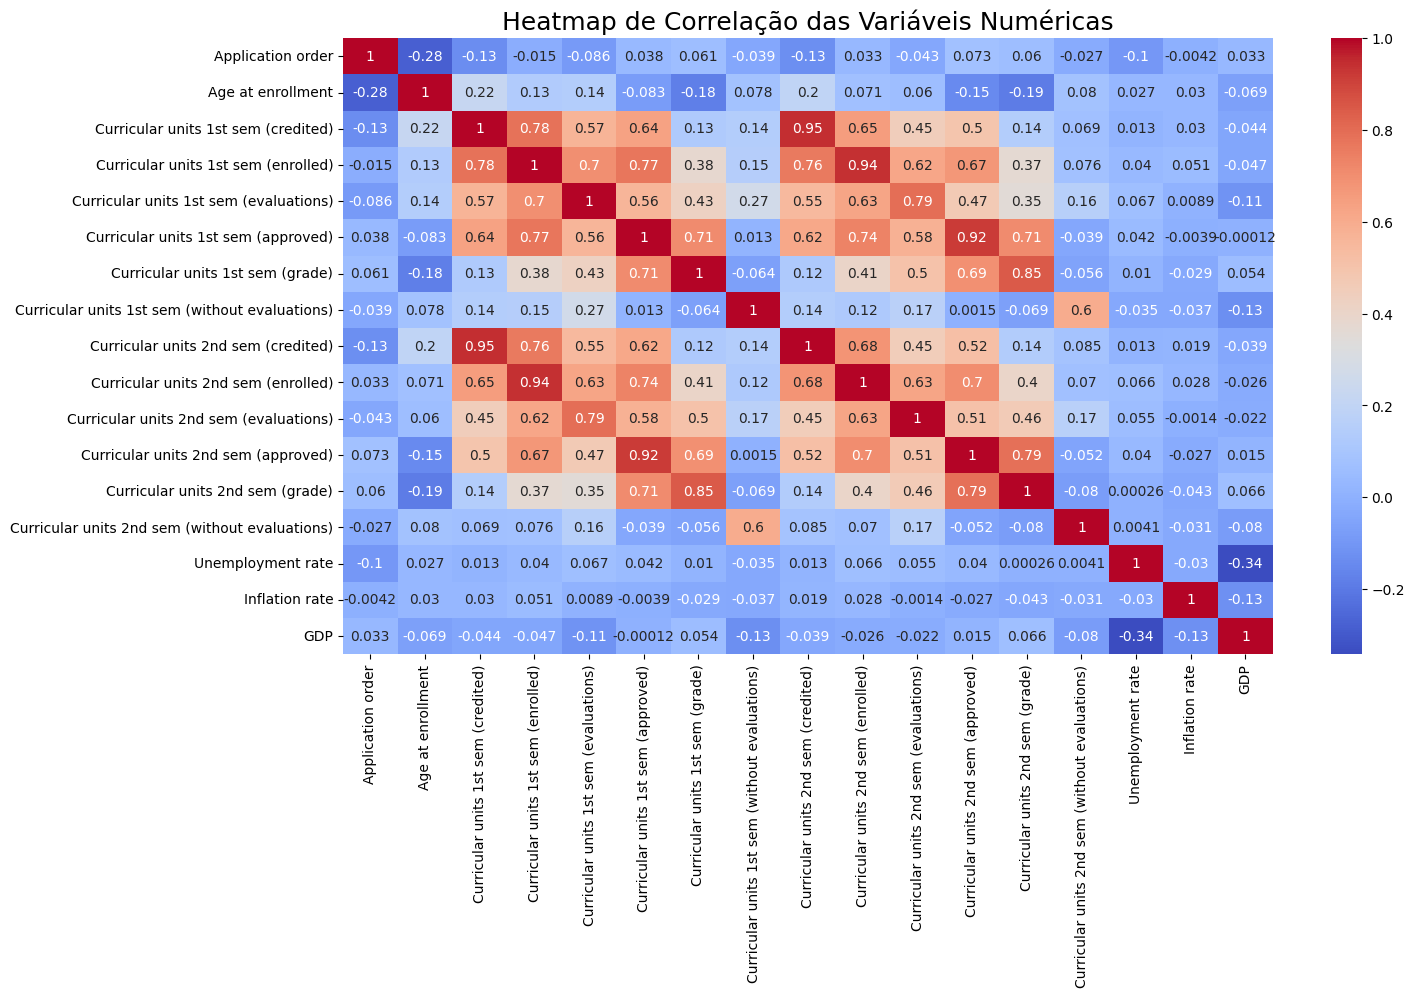

In [ ]:
numeric_cols = df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap of Numerical Variables', fontsize=18)
plt.show()

- **Within the same semester**: Variables such as enrolled units, evaluations, and approved units are strongly correlated. This makes sense: students who enroll in more subjects tend to have more evaluations and pass more units. The semester grade also has a very strong correlation with approved units, with a value of 0.71 in the 1st semester.

- **Between semesters (Important insight)**: The strongest and most important correlation is between the performance of the 1st and 2nd semesters. The 1st semester grade (1st sem (grade)) has a correlation of 0.85 with the 2nd semester grade. Similarly, approved units in the 1st semester have a correlation of 0.92 with those of the 2nd semester. This proves that past academic performance is an extremely strong predictor of future performance.

- **Possible Multicollinearity**: The "hot block" involving the variables `Curricular units ...` is a strong indication of multicollinearity. This will be analyzed later using the Variance Inflation Factor (VIF) technique.


### Testes de Hipótese

#### ANOVA (Analysis of Variance):  
Tests whether there is a statistically significant difference between the means of a numerical variable across two or more groups of a categorical variable.


- **ANOVA question**: "Is this categorical variable associated with significant differences in the mean of a continuous variable?"
    - If yes, it provides useful information and can be a good candidate as an explanatory variable.

1. **Null hypothesis** ($H_0$):
    - There is no significant difference between the groups.
    - In other words: the categorical variable has no effect on the numerical variable.
    - The group (category) means are equal.

➡ This implies there is no statistical association between the variables. It may be possible to consider discarding one of the variables or performing feature engineering.

2. **Alternative hypothesis** ($H_1$):
    - There is at least one significant difference between the groups.
    - In other words: the categorical variable has an effect on the numerical variable.
    - The group means are different.

➡ This indicates a significant association between the categorical and numerical variables. Feature engineering may not be necessary at this point because the relationship is already clear, but it may still be worthwhile to improve the representation.


- $p > 0.05$ >>> Do not reject $H_0$ → There is no evidence of differences between the groups → No association
- $p \leq 0.05$ >>> Reject $H_0$ and accept $H_1$ → There is evidence that the groups differ → There is an association


In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

if 'Target' in categorical_features:
    categorical_features.remove('Target')

anova_results = []

for cat_col in categorical_features:
    for num_col in numerical_features:
        # Skip if the categorical variable has too many categories (makes test slow/unreliable)
        if df[cat_col].nunique() > 50:
            continue

        # Group numerical data by the categories of the categorical variable
        groups = df.groupby(cat_col)[num_col].apply(list)

        if len(groups) < 2:
            continue

        try:
            f_statistic, p_value = f_oneway(*groups)
            anova_results.append({
                'Categorical Variable': cat_col,
                'Numerical Variable': num_col,
                'F Statistic': f_statistic,
                'p-value': p_value
            })
        except Exception as e:
            pass

results_df = pd.DataFrame(anova_results)

results_df_sorted = results_df.sort_values(by='p-value', ascending=True)

print("Displaying the 15 most significant relationships:")
display(results_df_sorted.head(15))

print("Displaying the 15 least significant relationships:")
display(results_df_sorted.tail(15))

Exibindo as 15 relações mais significativas:


,Variável Categórica,Variável Numérica,Estatístfor o núcleoica F,p-valor
18,Application mode,Age at enrollment,280.745529,0.000000e+00
1,Marital status,Age at enrollment,502.811925,0.000000e+00
43,Course,Curricular units 2nd sem (enrolled),118.447943,1.049518e-315
35,Course,Age at enrollment,80.506006,6.580430e-225
37,Course,Curricular units 1st sem (enrolled),72.907779,1.995195e-205
19,Application mode,Curricular units 1st sem (credited),67.502645,1.850651e-201
69,Previous qualification,Age at enrollment,71.022735,1.607919e-200
52,Daytime/evening attendance,Age at enrollment,940.584260,7.200418e-184
25,Application mode,Curricular units 2nd sem (credited),58.741694,7.155714e-177
40,Course,Curricular units 1st sem (grade),60.424144,2.246295e-172


Exibindo as 15 relações menos significativas:


,Variável Categórica,Variável Numérica,Estatístfor o núcleoica F,p-valor
276,International,Curricular units 1st sem (evaluations),0.163568,0.685916
280,International,Curricular units 2nd sem (credited),0.141132,0.707180
162,Father's occupation,Curricular units 2nd sem (enrolled),0.868774,0.707389
287,International,Inflation rate,0.126691,0.721909
265,Scholarship holder,Curricular units 2nd sem (evaluations),0.126421,0.722193
277,International,Curricular units 1st sem (approved),0.112094,0.737792
67,Daytime/evening attendance,GDP,0.090973,0.762961
253,Gender,Inflation rate,0.072378,0.787921
202,Educational special needs,Inflation rate,0.071908,0.788594
97,Nacionality,Curricular units 2nd sem (grade),0.722345,0.791122


- **Age at Enrollment is Central**: The student's age is the numerical variable most influenced by categorical factors. It is strongly associated with Marital Status, Application Mode, Course, Previous Qualification, and whether the student is Displaced. This indicates that different demographic profiles enter the university at significantly different ages, which by itself is a powerful behavior grouping factor.

- **The Course Defines Performance**: As expected, the chosen course has a massive impact on all academic performance metrics: enrolled units, grades, and approved units. This confirms that the difficulty and workload vary drastically between courses, making this one of the most important features for predicting student success.

- **History Matters**: Previous Qualification and Application Mode are strongly linked to both age and initial credits. This shows that the "background" the student brings to the university already places them on a distinct performance trajectory.


- **International Status is a Weak Predictor (Alone)**: The most notable finding here is that being an international student or not has no statistically significant association with almost any academic performance metric (grades, approvals, evaluations). This suggests that, in this dataset, the performance of international students is statistically indistinguishable from that of domestic students, making this variable alone a weak predictor.

- **Secondary Demographics with Low Impact**: Variables such as Father's Occupation, Nationality, and Gender, when crossed with numerical metrics, showed a very weak relationship (high p-value). They likely have less direct predictive power than the variables in the first table.

- **Diffuse Macroeconomic Factors**: Inflation Rate and GDP showed no association with individual characteristics such as gender or nationality, which makes sense since they are indicators that affect everyone more broadly and less directly.


#### Qui-Quadrado

This test evaluates whether there is a statistically significant association between two categorical variables. The null hypothesis $H_0$ is that the variables are independent (no association, with $p > 0.05$), and the alternative hypothesis $H_1$ is that there is an association ($p \leq 0.05$).

The Chi-Square test can analyze associations between our Target variable (which is categorical) and other explanatory categorical variables.

**Note**: ANOVA analyzes the impact of a categorical variable on the means of a numerical variable. The categorical variable defines the groups (for example: `passed`, `failed`, `dropped out`), and the numerical variable is the one being analyzed for differences between these groups (e.g., average grades, study hours, income, etc.). In our case, we want to know if the categorical `Target` variable (school dropout) can be explained by a numerical variable (e.g., income, age, grade), but ANOVA is not designed to test this directly because ANOVA focuses on the numerical variable as the variable of interest and the categorical as the explanatory variable—not the other way around. The Chi-Square test is used to address this issue.


Relações mais significativas:


,Variável 1,Variável 2,Estatística Chi2,p-valor
20,Application mode,Nacionality,3375.483418,0.000000e+00
19,Application mode,Previous qualification,10302.630410,0.000000e+00
33,Course,Daytime/evening attendance,3630.000000,0.000000e+00
108,Mother's occupation,Father's occupation,42264.249558,0.000000e+00
87,Mother's qualification,Father's qualification,20115.447190,0.000000e+00
85,Nacionality,International,3630.000000,0.000000e+00
89,Mother's qualification,Father's occupation,5888.401307,0.000000e+00
88,Mother's qualification,Mother's occupation,7165.054597,0.000000e+00
99,Father's qualification,Father's occupation,5162.093150,0.000000e+00
98,Father's qualification,Mother's occupation,3494.673706,3.329569e-294




Associações mais fortes com a variável 'Target':


,Variável 1,Variável 2,Estatística Chi2,p-valor
146,Tuition fees up to date,Target,706.955139,9.189124e-156
47,Course,Target,442.947968,3.497695e-84
151,Scholarship holder,Target,354.219302,5.109075e-79
32,Application mode,Target,392.065918,8.435153e-73
142,Debtor,Target,257.459618,6.141424e-58
149,Gender,Target,229.351510,8.255974e-52
74,Previous qualification,Target,150.599021,5.952453e-24
97,Mother's qualification,Target,143.014288,2.201217e-17
116,Mother's occupation,Target,138.235113,1.555138e-16
107,Father's qualification,Target,147.861704,1.754550e-16


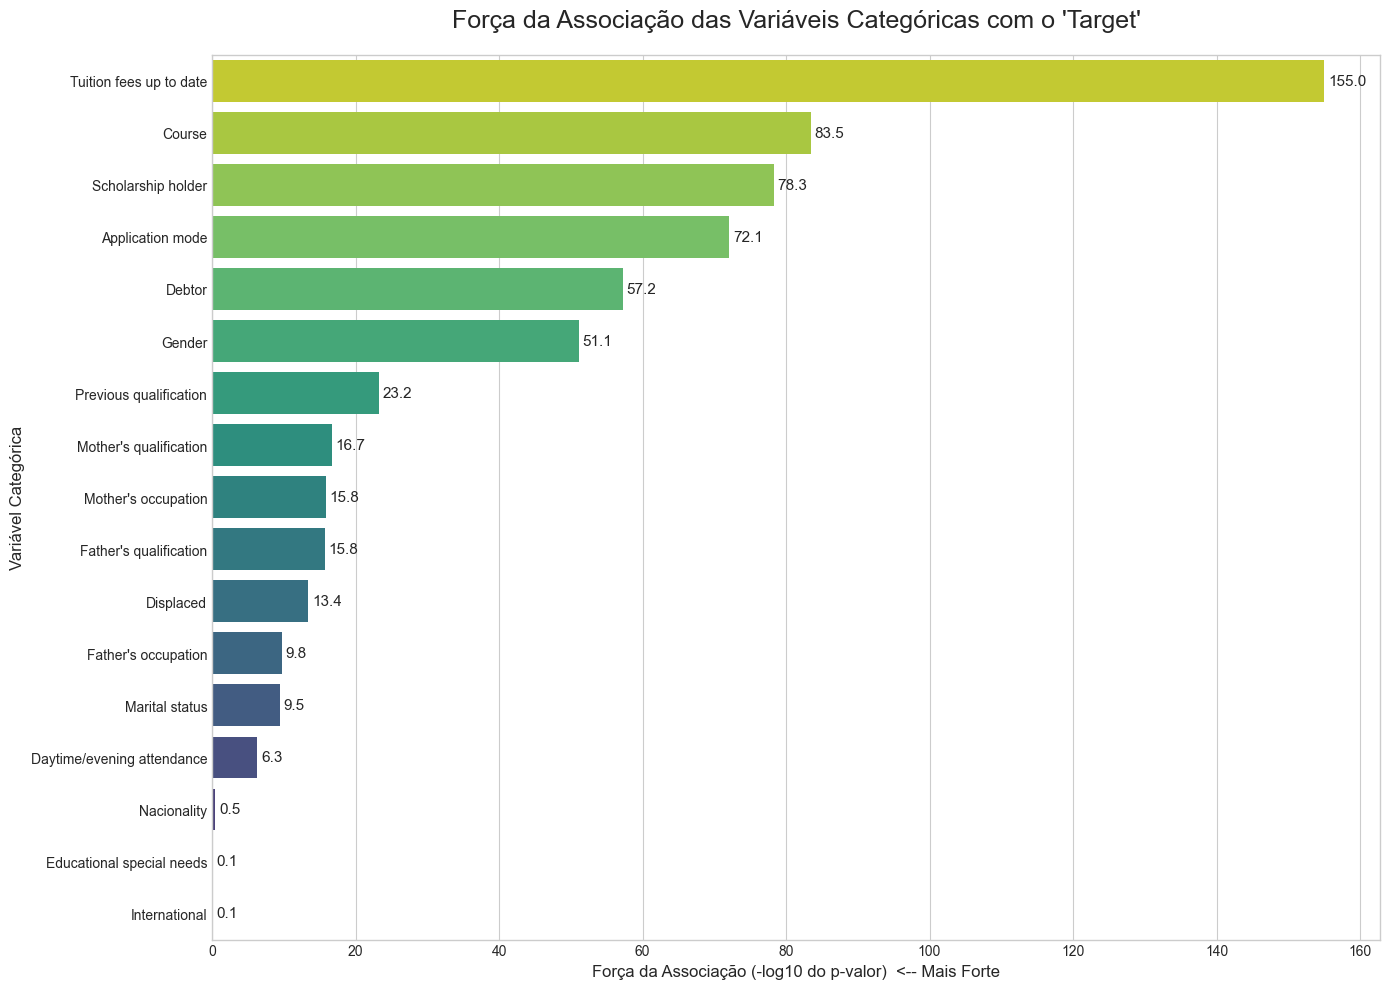

In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_pairs = list(combinations(categorical_features, 2))
chi2_results = []

for pair in cat_pairs:
    var1, var2 = pair[0], pair[1]
    
    contingency_table = pd.crosstab(df[var1], df[var2])
    
    try:
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'Chi2 Statistic': chi2,
            'p-value': p_value
        })
    except Exception as e:
        # Some tables may have zero counts, which can cause the test to fail
        pass

results_df = pd.DataFrame(chi2_results)

results_df_sorted = results_df.sort_values(by='p-value', ascending=True)

print("Most significant relationships:")
display(results_df_sorted.head(20))

print("\n\nStrongest associations with the 'Target' variable:")
target_associations = results_df_sorted[
    (results_df_sorted['Variable 1'] == 'Target') | (results_df_sorted['Variable 2'] == 'Target')
].copy()
display(target_associations.head(20))

target_associations['Feature'] = target_associations.apply(
    lambda row: row['Variable 1'] if row['Variable 2'] == 'Target' else row['Variable 2'],
    axis=1
)

target_associations['Association Strength (-log10 p-value)'] = -np.log10(target_associations['p-value'].replace(0, 1e-300))

plot_data = target_associations.sort_values(by='Association Strength (-log10 p-value)', ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=plot_data,
    x='Association Strength (-log10 p-value)',
    y='Feature',
    palette='viridis_r',
    orient='h'
)

ax.set_title("Association Strength of Categorical Variables with 'Target'", fontsize=18, pad=20)
ax.set_xlabel('Association Strength (-log10 p-value)  <-- Stronger', fontsize=12)
ax.set_ylabel('Categorical Variable', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height() / 2,
            f'{width:.1f}',
            va='center',
            fontsize=11)

plt.tight_layout()
plt.show()


##### Tier 1: The Dominant Predictors (p-value $< e^{-50}$)

These are the variables with the strongest connection to dropout. They should be present in any predictive model that is built.

- **Tuition fees up to date**: With an astronomical p-value of approximately $e^{-156}$, this is by far the most impactful variable. The association is so strong that the student's financial status with the institution is almost a verdict on their outcome. The message is clear: financial difficulty is the main cause of dropout.

- **Course**: The second strongest variable. It confirms that the course chosen by the student is a determining factor for their success. Some courses may have intrinsically higher dropout rates due to difficulty, structure, or market alignment.

- **Scholarship holder**: Acts as the opposite of tuition status. Having a scholarship, which alleviates financial pressure and often selects high-merit students, has a massive protective effect against dropout.

- **Application mode and Debtor**: Complete this group of significant variables. The path by which the student entered the university and their debt status are critical factors.

- **Gender**: Surprisingly, Gender appears with an extremely strong association. This does not mean one gender is "better" than the other, but rather that, in this dataset, dropout and graduation patterns between men and women are statistically very different. It would be interesting to investigate this further (e.g., dropout by gender within each course).

Main Insight from Tier 1: The student's financial health and primary academic choices are the pillars supporting their university journey.


##### Tier 2: Contextual Factors (p-value between $e^{-10}$ and $e^{-24}$)

These variables, although not as dominant as those in Tier 1, are still very strong predictors and add great context about the student's profile.

- **Parents' Qualification and Occupation (Mother's/Father's qualification/occupation)**: This block of variables acts as a strong indicator of the student's socioeconomic and cultural background. A higher educational level of the parents is clearly associated with a lower chance of dropout, likely indicating a family environment that values education more and provides greater support.

- **Academic History (Previous qualification)**: The student's prior education remains a robust predictor of their future success.

- **Personal Circumstances (Displaced, Marital status, Daytime/evening attendance)**: Factors describing the student's "life outside the university" also carry significant weight. Being displaced (away from home), marital status, and studying at night (usually indicating simultaneous work) are circumstances that directly impact the student's ability to stay enrolled.

Main Insight from Tier 2: The student's social, family, and personal context provides the second most important layer of predictive information.


##### Tier 3: Marginal or Weak Predictors (p-value $> e^{-1}$)

These variables are at the bottom of the list and should be treated with caution, as they may add more noise to a model than help predict the target variable.

- **Nationality**: Although still statistically significant (p-value ~0.034 < 0.05), its strength of association is orders of magnitude weaker than the other groups. It may add some information, but its impact is small.

- **Educational special needs and International**: With p-values of ~0.78 and ~0.79 respectively, these variables have no statistically significant association with the Target. This confirms what was already seen in the ANOVA test for International. This may mean that institutional support for these groups is effective, or that other factors are so dominant they overshadow the isolated effect of these conditions.

Main Insight from Tier 3: Contrary to common belief, being an international student or having a registered special need are not, by themselves, risk factors for dropout in this dataset.


### Variance Inflation Factor (VIF) – Multicollinearity Diagnosis

For a variable $X_i$, the $VIF$ is defined as:

$$
\text{VIF}_i = \frac{1}{1 - R_i^2}
$$

Where:

- $R_i^2$ is the coefficient of determination from regressing variable $X_i$ on all other explanatory variables.

VIF asks: "Is this variable highly correlated with the other variables in the model?"
- If yes, it introduces redundancy and may impair the interpretation of the regression.

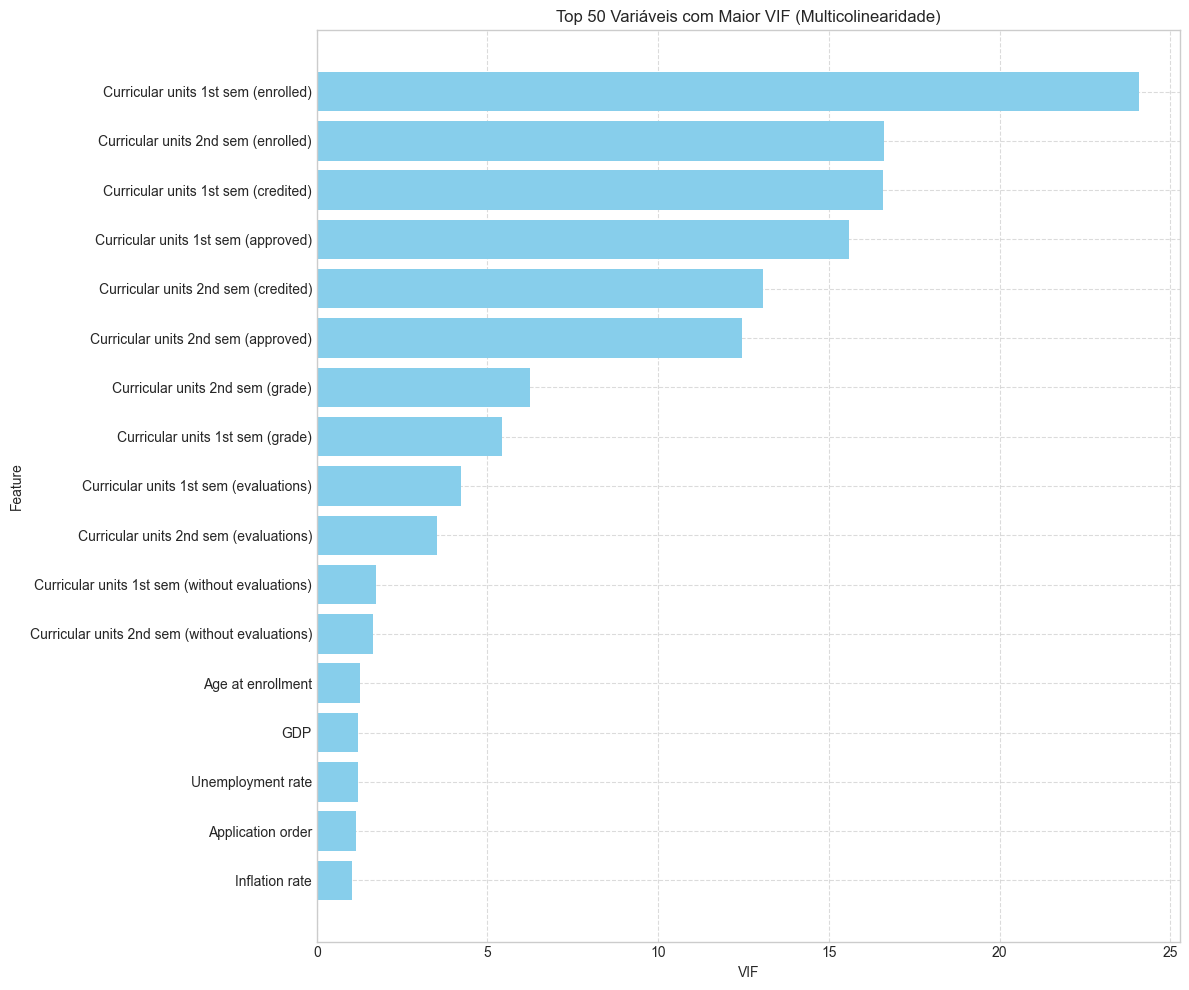

In [ ]:
X_numeric = df.select_dtypes(include=np.number).dropna()
X_const = add_constant(X_numeric)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

top_vif = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False).head(50)

plt.figure(figsize=(12, 10))
plt.barh(top_vif["feature"], top_vif["VIF"], color="skyblue")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Top 50 Variables with Highest VIF (Multicollinearity)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Interpretation of VIF Values

- $VIF = 1$: No multicollinearity  
- $1 < VIF < 5$: Low multicollinearity  
- $5 < VIF < 10$: Moderate multicollinearity (caution)  
- $VIF > 10$: High multicollinearity (problematic)  

A high VIF value is problematic for several reasons. First, it indicates unstable coefficients because the model has difficulty distinguishing the individual effects of correlated variables. Additionally, there is redundancy, as the variable with a high VIF usually does not add new information and can be predicted by the others. This can also lead to overfitting, as the model excessively fits the training data by incorporating variables that do not effectively contribute to explaining the target variable. Finally, there is difficulty in interpretation, since it becomes confusing to identify which variable is truly impacting the response.


- **Extremely High VIF (> 10)**: The variables Curricular units 1st/2nd sem (enrolled), (credited), and (approved) show very high VIFs, reaching 24.08. This means that over 95% of the variance of Curricular units 1st sem (enrolled) can be explained by the other numerical variables.
- **High VIF (> 5)**: The grade variables also show elevated VIF.

**Main Insight**: This is completely expected and logical. The number of subjects a student enrolls in (enrolled), the number they validate (credited), and the number they pass (approved) are intrinsically linked. They are different measures of the same fundamental concept: the volume and academic success of the student in a semester.

High multicollinearity in the academic block can be problematic, especially for linear models (like Logistic Regression), as it makes the model coefficients unstable and difficult to interpret.

##### Possible Strategies

- Careful removal of features with high VIF;
- Feature engineering: combine correlated variables to create new, more powerful features that resolve multicollinearity.
- Use models naturally more robust to multicollinearity, such as Random Forest, LightGBM, XGBoost, and other ensemble-based models.


### Skewness Analysis and Outlier Detection

Skewness measures the degree of distortion of a variable’s distribution relative to a symmetric distribution (bell curve). Outliers are data points that deviate drastically from the others.

Why use it?

- Some models, like Linear Regression and SVMs, perform better with data that have a distribution close to normal (low skewness).

- Identifying outliers helps us understand whether they are data entry errors that need correction or legitimate extreme cases that contain important information about student behavior.



--- Gráficos de Densidade de Kernel (KDE) ---


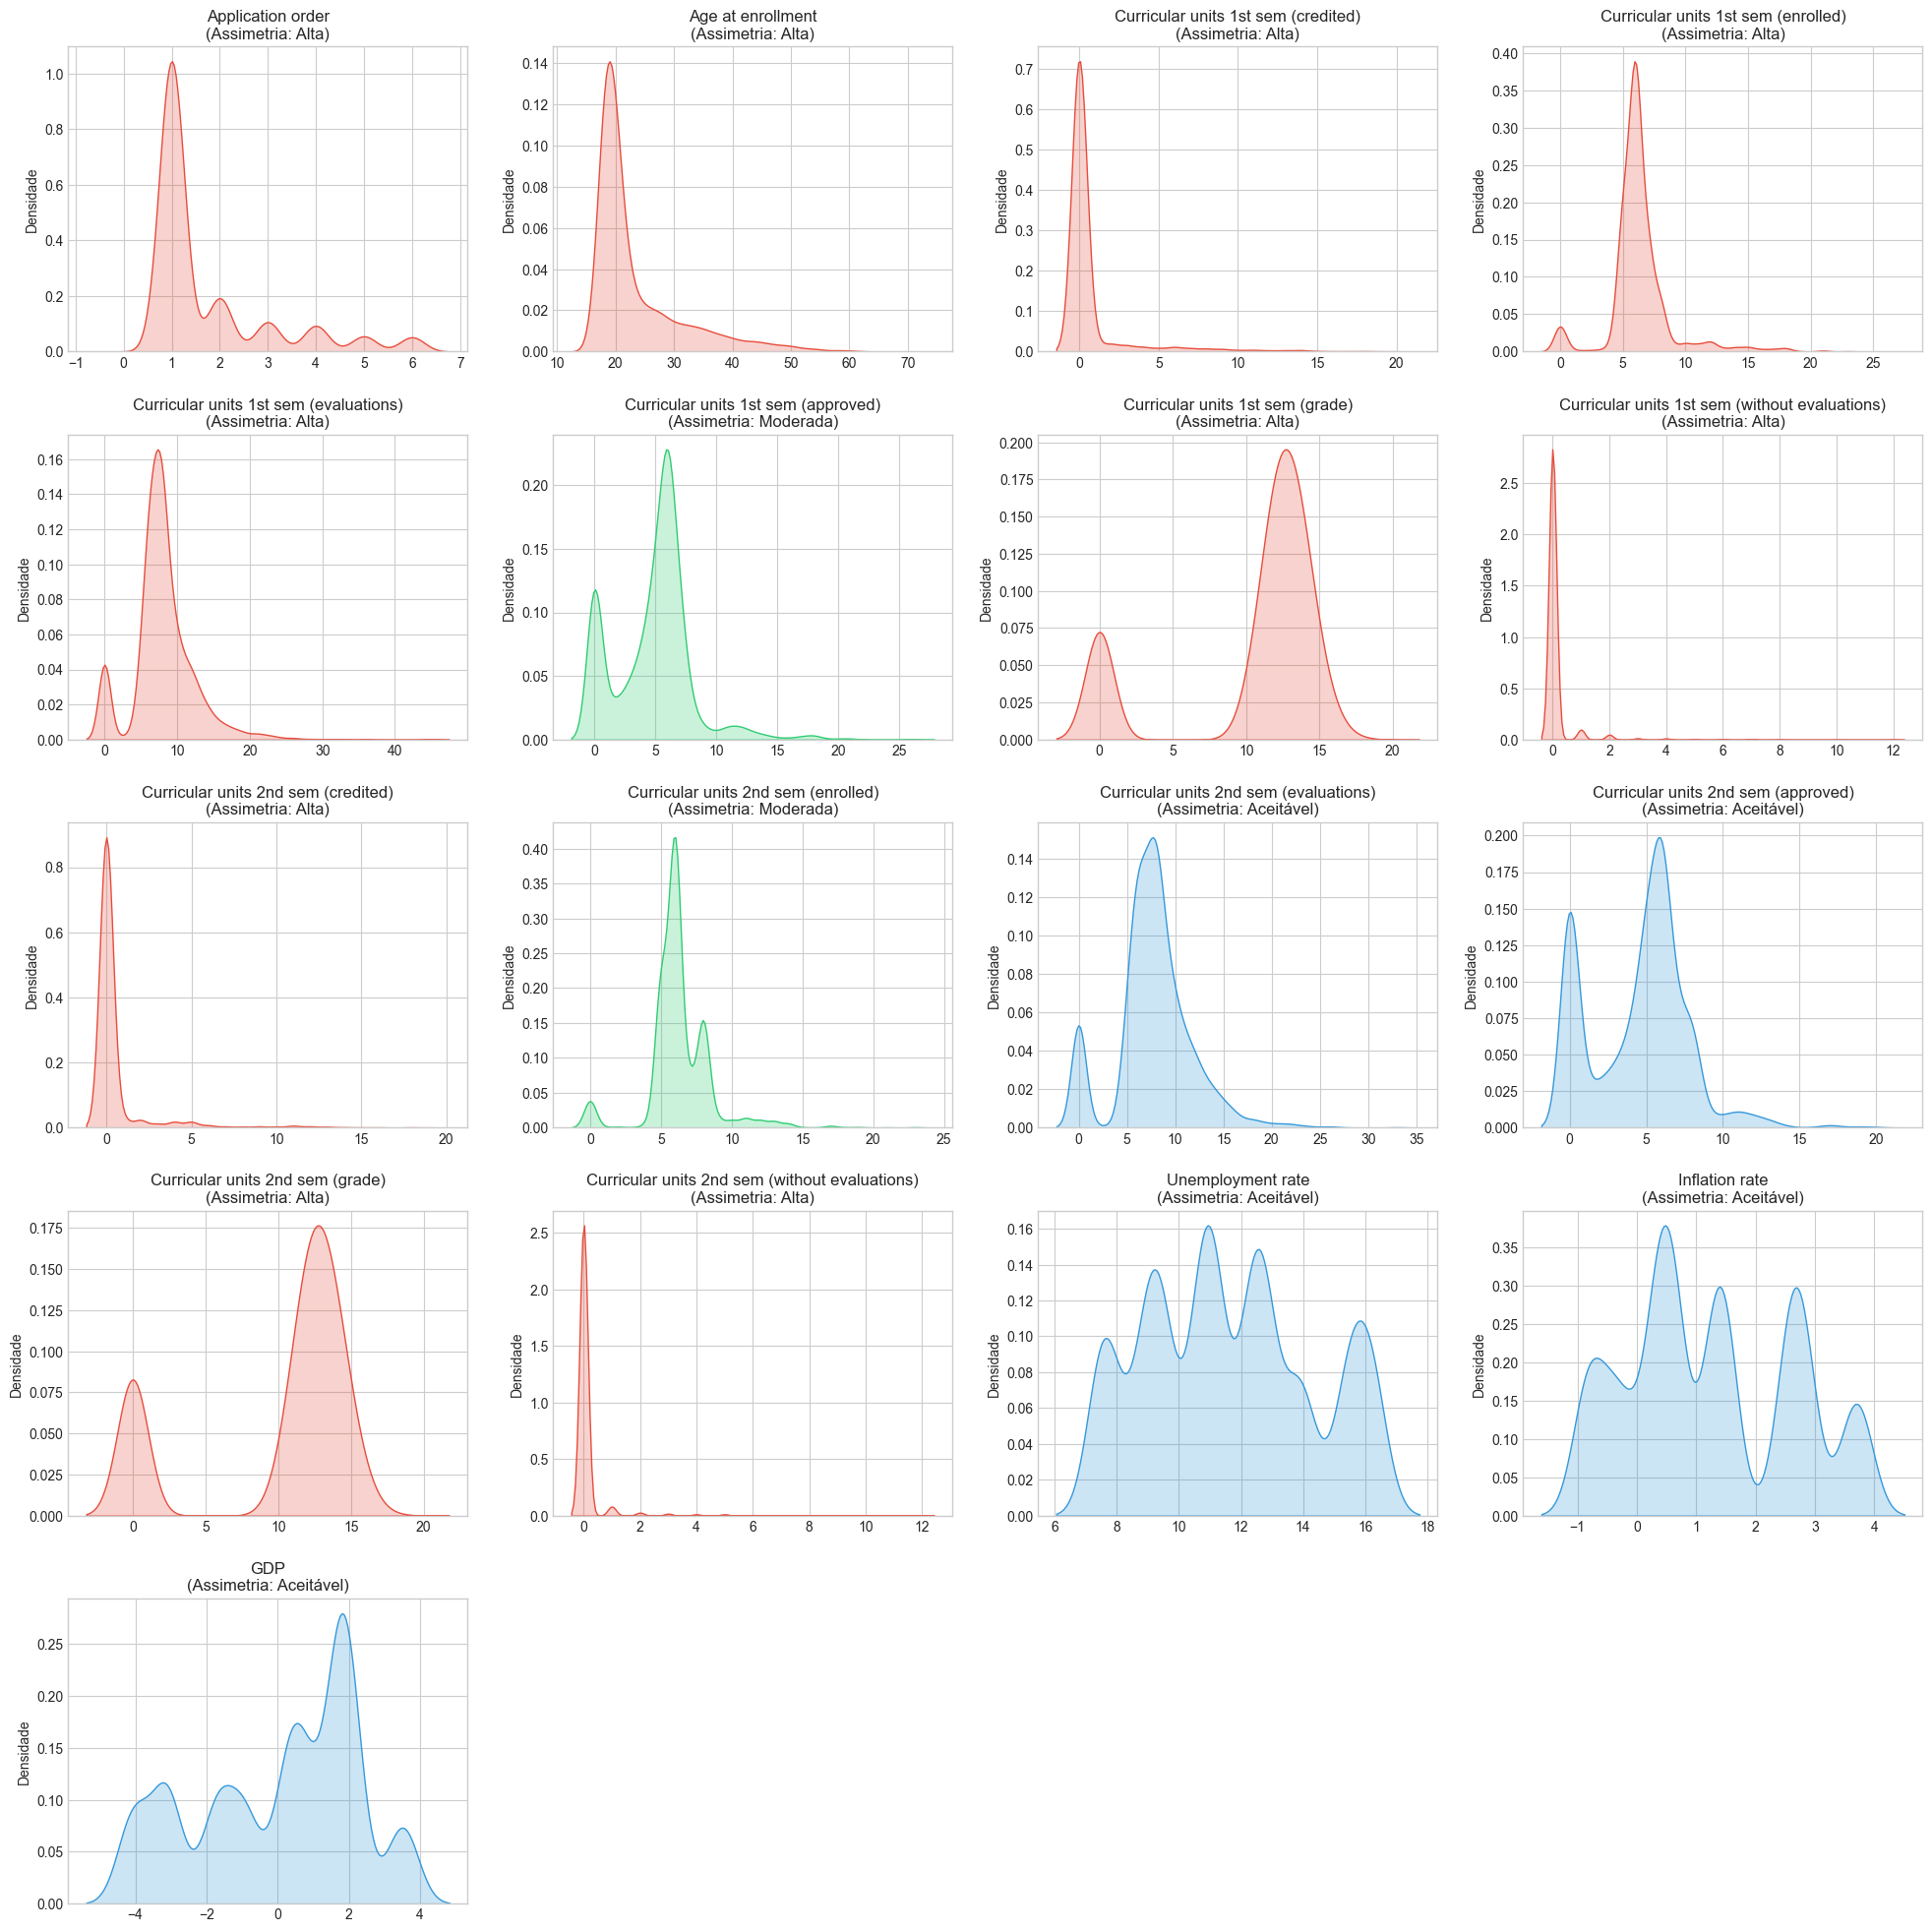

,Skewness,Tipo de Assimetria
Curricular units 1st sem (without evaluations),8.719276,Alta
Curricular units 2nd sem (without evaluations),7.615448,Alta
Curricular units 2nd sem (credited),4.494329,Alta
Curricular units 1st sem (credited),4.064552,Alta
Age at enrollment,1.990725,Alta
Application order,1.817973,Alta
Curricular units 1st sem (enrolled),1.651648,Alta
Curricular units 1st sem (grade),-1.451853,Alta
Curricular units 2nd sem (grade),-1.167812,Alta
Curricular units 1st sem (evaluations),1.146086,Alta


In [ ]:
numerical_features = df.select_dtypes(include=np.number)

skewness = numerical_features.skew()
skew_df = pd.DataFrame(skewness, columns=['Skewness']) 

skew_df['Skewness Type'] = skew_df['Skewness'].apply(
    lambda x: 'High' if abs(x) > 1 else 'Moderate' if abs(x) >= 0.5 else 'Acceptable'
)

color_map = {
    'High': '#E74C3C',
    'Moderate': '#2ECC71',
    'Acceptable': '#3498DB'
}

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

print("\n--- Kernel Density Estimation (KDE) Plots ---")
for i, col in enumerate(numerical_features.columns):
    skew_type = skew_df.loc[col, 'Skewness Type']
    plot_color = color_map[skew_type]

    sns.kdeplot(ax=axes[i], data=df, x=col, fill=True, color=plot_color)
    
    axes[i].set_title(f'{col}\n(Skewness: {skew_type})', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

skew_df_sorted = skew_df.sort_values(by='Skewness', key=abs, ascending=False)
display(skew_df_sorted)


- The variables with the highest positive skewness by far are `Curricular units (without evaluations)` and `Curricular units (credited)`. This indicates an "all or nothing" behavior. The vast majority of students have a value of zero for these variables (i.e., they participate in all evaluations and have no previous credits to validate). However, a small minority of students deviate from this pattern (either by not attending evaluations or transferring with many credits), creating a long positive tail in the distribution. These are not just variables; they are strong indicators of distinct student profiles: the disengaged student and the transfer student.

- The only variables with significant negative skewness are the grades from the 1st and 2nd semesters. This is caused by a "ceiling effect." The grading scale has a maximum value (e.g., 20). Most students who remain in the course and pass tend to perform well, with grades concentrated near the top of the scale. A smaller number of students perform very poorly, which "pulls" the tail of the distribution to the left (towards zero). This suggests that very low grades are the exception, not the rule.


For variables with high skewness (both positive and negative), it is highly recommended to apply a transformation (such as the logarithmic transformation, `np.log1p`) before training models sensitive to scale, like Logistic Regression, SVM, Naive Bayes, or Neural Networks. This helps the model perform better.




--- Detecção Visual de Outliers ---


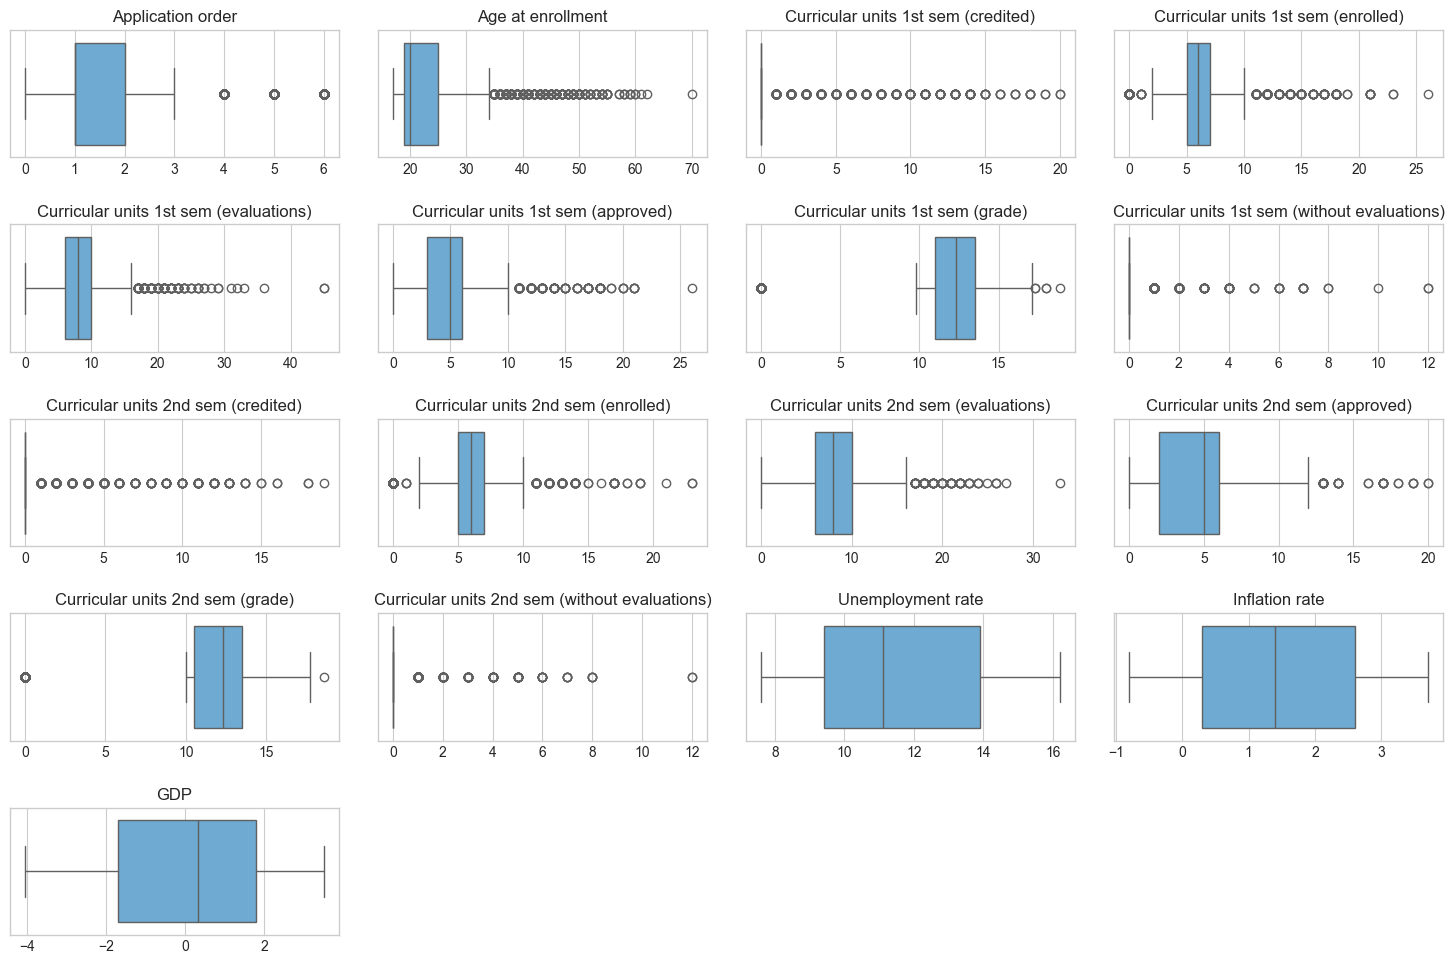

In [ ]:
print("\n\n--- Visual Outlier Detection ---")

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))
axes = axes.flatten()
    
for i, col in enumerate(numerical_features.columns):
    sns.boxplot(ax=axes[i], x=numerical_features[col], color='#5DADE2')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

- **Age at enrollment**: The box plot clearly shows a concentration of students in the traditional age range (18-22 years). The numerous outlier points on the right, going up to 70 years old, are mature students. They are a distinct and essential demographic group for the analysis, not errors.

- **Curricular units ... (credited)**: The box is flattened at zero, meaning most students do not validate any subjects. All outlier points are actually transfer students or those with previous qualifications.

- **Curricular units ... (without evaluations)**: This is perhaps the most critical insight. The box is also flattened at zero, indicating that the normal behavior is to participate in all evaluations. The outliers, therefore, are the disengaged students. Each point here is a strong early warning sign of dropout.

- **Curricular units ... (grade)**: The outliers here are mainly at the lower end. While most students concentrate on higher grades (the "box"), low-grade outliers represent students with significant academic difficulties, who are most likely to drop out.

- **Curricular units ... (approved)**: Outliers at the upper end represent high-performing students who manage to pass a number of subjects well above average.

- **Macroeconomic Data (Unemployment rate, Inflation rate, GDP)**: As expected, these variables show much more symmetric distributions with few or no outliers. This occurs because they are aggregate economic data, not reflecting extreme individual behaviors.

##### Conclusion

No outliers should be removed. Removing these points would erase information about the most important profiles for a predictive model: mature students, transfer students, disengaged students, and those with very low performance. This would drastically impair the model’s ability to predict dropout.


# Feature Engineering

The feature engineering step is where the insights from our exploratory and statistical analysis are used to transform raw data into much clearer and enriched "signals" for a predictive model. The better the quality of the features, the better the model.

Mathematical models do not understand raw text (like `Dropout` or `Graduate`). These need to be converted into numbers, and the best approach depends on the nature of each variable. Therefore, we use a hybrid strategy based on cardinality (the number of unique categories):

| Feature                 | One-Hot Encoding (`OneHotEncoder`)                                                                              | Target Encoding (`TargetEncoder`)                                                                                            |
|:------------------------|:----------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------|
| **What it does?**       | Creates a new binary column (0 or 1) for **each category** of the original variable.                             | Replaces each category with a **single number**: the mean of the target for that category.                                   |
| **When to use?**        | Variables with **low cardinality** (few unique categories, e.g., 2 to 5). <br> *Ex: `Gender`, `Displaced`.*      | Variables with **high cardinality** (many unique categories, e.g., 6 or more). <br> *Ex: `Course`, `Mother's occupation`.*   |
| **Main advantage**      | Complete and "honest" representation of the data, without assuming order or value relationships between categories. | Extremely efficient. Captures predictive power in a single column, avoiding the "curse of dimensionality."                   |
| **Main disadvantage**   | Unfeasible for high cardinality (creates too many columns, e.g., 30 courses → 29 new columns).                   | Higher risk of overfitting. Requires careful techniques (such as cross-validation) to be robust.                             |
| **Practical example**   | The `Gender` column with values 'Male' and 'Female' is transformed into the `Gender_Male` column with values 0 or 1. | The category `'Nursing'` in the `Course` column is replaced by the value `0.18` (if the dropout rate in Nursing is 18%).      |


In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_weak_features=True, rare_threshold=0.01):
        self.drop_weak_features = drop_weak_features
        self.rare_threshold = rare_threshold

    def fit(self, X, y):
        if not isinstance(y, pd.Series):
            y = pd.Series(y, name='Target')
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not is_numeric_dtype(y) or y.dtype.name == 'category':
            if y.unique().tolist() == ['Graduate', 'Dropout'] or 'Dropout' in y.unique().tolist():
                y = y.apply(lambda x: 1 if x == 'Dropout' else 0).rename('Target')
            else:
                y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int) 

        self.course_grade_map_1sem_ = X.groupby('Course', observed=False)['Curricular units 1st sem (grade)'].mean()
        self.course_grade_map_2sem_ = X.groupby('Course', observed=False)['Curricular units 2nd sem (grade)'].mean()
        self.global_grade_mean_1sem_ = X['Curricular units 1st sem (grade)'].mean()
        self.global_grade_mean_2sem_ = X['Curricular units 2nd sem (grade)'].mean()

        original_categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.ohe_cols_ = [col for col in original_categorical_cols if X[col].nunique() <= 5]
        self.target_cols_ = [col for col in original_categorical_cols if X[col].nunique() > 5]
        
        self.target_cols_.append('course_gender_interaction')
        self.ohe_cols_.append('age_group')

        # Logic to learn which categories are rare across ALL original categorical columns
        self.rare_maps_ = {}
        # Parents' qualifications are treated numerically, so we exclude them here.
        cols_to_check_for_rares = [col for col in original_categorical_cols if col not in ["Mother's qualification", "Father's qualification"]]
        for col in cols_to_check_for_rares:
            counts = X[col].value_counts(normalize=True)
            rare_cats = counts[counts < self.rare_threshold].index.tolist()
            if rare_cats:
                self.rare_maps_[col] = rare_cats

        X_temp_for_fit = X.copy()
        for col, rare_list in self.rare_maps_.items():
            X_temp_for_fit[col] = X_temp_for_fit[col].astype(str).replace(rare_list, 'Other')
        
        X_temp_for_fit['course_gender_interaction'] = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
        X_temp_for_fit['age_group'] = pd.cut(
            X_temp_for_fit['Age at enrollment'],
            bins=[0, 20, 25, 40, 100],
            labels=['Traditional_Young', 'Traditional_Adult', 'Mature', 'Mature_Senior'],
            right=False
        )

        for col in self.target_cols_ + self.ohe_cols_:
            if col in X_temp_for_fit.columns:
                X_temp_for_fit[col] = X_temp_for_fit[col].astype(str)
        
        self.target_maps_ = {}
        self.global_mean_ = y.mean()
        for col in self.target_cols_:
            if col == 'course_gender_interaction':
                interaction_series = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
                self.target_maps_[col] = pd.concat([interaction_series.rename(col), y], axis=1).groupby(col, observed=False)[y.name].mean()
            else:
                self.target_maps_[col] = pd.concat([X_temp_for_fit[col], y], axis=1).groupby(col, observed=False)[y.name].mean()
        
        self.target_encoder_ = TargetEncoder(target_type='binary')
        self.target_encoder_.fit(X_temp_for_fit[self.target_cols_], y)

        self.ohe_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
        self.ohe_.fit(X_temp_for_fit[self.ohe_cols_])
        
        return self

    def transform(self, X):
        X_transformed = X.copy()

        X_transformed['parent_education_level'] = (X_transformed["Mother's qualification"].astype(int) + X_transformed["Father's qualification"].astype(int))
        X_transformed['financial_stress_index'] = (X_transformed['Debtor'].astype(int) - X_transformed['Scholarship holder'].astype(int) + (1 - X_transformed['Tuition fees up to date'].astype(int)))

        for col, rare_list in self.rare_maps_.items():
            X_transformed[col] = X_transformed[col].astype(str).replace(rare_list, 'Other')

        X_transformed['course_gender_interaction'] = X_transformed['Course'].astype(str) + '_' + X_transformed['Gender'].astype(str)
        X_transformed['age_group'] = pd.cut(
            X_transformed['Age at enrollment'],
            bins=[0, 20, 25, 40, 100],
            labels=['Traditional_Young', 'Traditional_Adult', 'Mature', 'Mature_Senior'],
            right=False
        ).astype(str)
        
        if hasattr(self, 'course_grade_map_1sem_'):
            avg_grade_1sem = X_transformed['Course'].astype(str).map(self.course_grade_map_1sem_).fillna(self.global_grade_mean_1sem_)
            X_transformed['grade_deviation_1sem'] = X_transformed['Curricular units 1st sem (grade)'] - avg_grade_1sem
            avg_grade_2sem = X_transformed['Course'].astype(str).map(self.course_grade_map_2sem_).fillna(self.global_grade_mean_2sem_)
            X_transformed['grade_deviation_2sem'] = X_transformed['Curricular units 2nd sem (grade)'] - avg_grade_2sem

        rate_1 = X_transformed['Curricular units 1st sem (approved)'] / X_transformed['Curricular units 1st sem (enrolled)']
        X_transformed['approval_rate_1sem'] = rate_1.replace([np.inf, -np.inf], 0).fillna(0)
        rate_2 = X_transformed['Curricular units 2nd sem (approved)'] / X_transformed['Curricular units 2nd sem (enrolled)']
        X_transformed['approval_rate_2sem'] = rate_2.replace([np.inf, -np.inf], 0).fillna(0)
        
        X_transformed['academic_progress'] = X_transformed['approval_rate_2sem'] - X_transformed['approval_rate_1sem']
        total_without_evals = X_transformed['Curricular units 1st sem (without evaluations)'] + X_transformed['Curricular units 2nd sem (without evaluations)']
        X_transformed['disengaged_student'] = (total_without_evals > 0).astype(int)

        for col in self.target_cols_ + self.ohe_cols_:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].astype(str)
                
        target_encoded_data = self.target_encoder_.transform(X_transformed[self.target_cols_])
        target_encoded_df = pd.DataFrame(target_encoded_data, index=X_transformed.index, columns=[f"{c}_encoded" for c in self.target_cols_])

        ohe_data = self.ohe_.transform(X_transformed[self.ohe_cols_])
        ohe_df = pd.DataFrame(ohe_data, index=X_transformed.index, columns=self.ohe_.get_feature_names_out(self.ohe_cols_))
        
        X_final = X_transformed
        X_final = pd.concat([X_final, target_encoded_df, ohe_df], axis=1)

        cols_to_drop = [
            # Categorical features replaced by encoders
            'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 
            'Previous qualification', 'Nacionality', "Mother's occupation", 
            "Father's occupation", 'Displaced', 'Educational special needs', 'Gender', 'International',
            # Numerical features replaced by engineered features
            'Curricular units 1st sem (approved)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (grade)',
            'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (grade)',
            'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)',
            'Debtor', 'Tuition fees up to date', 'Scholarship holder', 
            "Mother's qualification", "Father's qualification", 'Age at enrollment'
        ]
        
        X_final = X_final.drop(columns=cols_to_drop, errors='ignore')
        X_final = X_final.drop(columns=['course_gender_interaction', 'age_group'], errors='ignore')

        if self.drop_weak_features:
            weak_features = [col for col in X_final.columns if 'International' in col or 'Educational special needs' in col]
            X_final = X_final.drop(columns=weak_features, errors='ignore')
            
        return X_final


The result is a fully numeric and enriched dataset, ready to be used by Machine Learning algorithms.

Encoded Features:  
- Columns ending with `_encoded` (e.g., `Course_encoded`) contain the Target Encoding values. Each value represents the average dropout rate associated with the original category, effectively measuring the "risk" of each category.  
- Columns ending with the category name (e.g., `age_group_Mature`) are the result of One-Hot Encoding. They are binary flags (0 or 1) indicating the presence or absence of a particular feature.

Original Features Retained: Numerical variables that did not exhibit high multicollinearity and were not replaced by engineered features (such as Application order and macroeconomic indicators) were kept in their original form.

- **To Reduce Multicollinearity (Insight from VIF and Correlation)**: We saw that the `Curricular units ...` variables were highly correlated. Instead of using them directly, we created rates like `approval_rate_ ...` (approved / enrolled), which are more informative and resolve redundancy.

- **To Capture Behaviors (Insight from Skewness and Outliers)**: The analysis showed that `Curricular units (without evaluations)` indicated an "all or nothing" behavior. The feature `disengaged_student` transforms this statistical observation into a clear and direct risk flag for the model.

- **To Combine Strong Predictors (Insight from Chi-Square and ANOVA)**: Our analysis showed that `Debtor`, `Tuition fees up to date`, and `Scholarship holder` were the strongest predictors. The feature `financial_stress_index` combines them into a single powerful indicator of the student's financial situation.

It is important to note that all the "learning" necessary for these transformations (such as the means for Target Encoding and the categories for One-Hot Encoding) must be done only with the training data, and testing data separately. This ensures there is no data leakage.


### Preprocessing of Skewed Distributions

To ensure that models sensitive to data distribution (such as Neural Networks, Logistic Regression, Naive Bayes, etc.) receive data in the most optimized format possible, two custom classes were developed that integrate with the Scikit-learn ecosystem: `ReflectionTransformer` and `DynamicPreprocessor`:

In [16]:
class ReflectionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_values_ = None

    def fit(self, X, y=None):
        self.max_values_ = X.max()
        return self

    def transform(self, X):
        return (self.max_values_ + 1) - X

In [ ]:
class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    """
    This class receives a dataframe with already created features, analyzes their
    distributions (skewness), and applies the correct preprocessing
    (log, reflection, scaling) to each subset of columns.
    """
    def __init__(self, positive_skew_threshold=1.0, negative_skew_threshold=-1.0):
        self.positive_skew_threshold = positive_skew_threshold
        self.negative_skew_threshold = negative_skew_threshold

    def fit(self, X, y=None):
        skewness = X.skew(numeric_only=False)
        
        self.positive_skew_features_ = skewness[skewness > self.positive_skew_threshold].index.tolist()
        self.negative_skew_features_ = skewness[skewness < self.negative_skew_threshold].index.tolist()
        
        all_numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        ohe_cols = [col for col in X.columns if '_' in col and X[col].nunique() <= 2]
        passthrough_features = ohe_cols + [col for col in X.columns if 'disengaged_student' in col]

        self.numeric_no_skew_features_ = [
            col for col in all_numeric_cols 
            if col not in self.positive_skew_features_ and col not in self.negative_skew_features_ and col not in passthrough_features
        ]

        self.preprocessor_ = ColumnTransformer(
            transformers=[
                ('pos_skew', SklearnPipeline(
                    steps=[
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.positive_skew_features_),
                ('neg_skew', SklearnPipeline(
                    steps=[
                        ('reflect', ReflectionTransformer()), 
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.negative_skew_features_),
                ('no_skew', StandardScaler(), self.numeric_no_skew_features_)
            ],
            remainder='passthrough'
        )
        
        self.preprocessor_.fit(X)
        return self

    def transform(self, X):
        return self.preprocessor_.transform(X)


1. `ReflectionTransformer`  
- **Purpose**: This class aims to handle variables with negative skewness. The logarithmic transformation (log), which is excellent for correcting skewness, only works on positively skewed distributions (with a long right tail). This class, therefore, serves as a preparatory step.

- **How it works**:  
    1. In the `.fit()` method, it learns the maximum value of each column from the training data.  
    2. In the `.transform()` method, it applies the formula `(max_value + 1) - original_value` to each data point. This effectively "reflects" or "inverts" the variable's distribution. A tail that was previously long on the left (negative skew) becomes a long right tail (positive skew).  

- **Role in the Pipeline**: It acts as the first step in handling features with negative skewness, preparing the ground so that the logarithmic transformation can be successfully applied in the next step.


2. `DynamicPreprocessor`  
- **Purpose**: This is the main orchestrator class of our preprocessing. Its role is to intelligently automate and apply the correct treatment for each type of numeric feature, eliminating the need to manually select which columns should receive which transformation.  
- **How it works**: The class operates in two phases:  
    1. **Fit phase (Analysis and Planning):** This is the "intelligence" of the component. Upon receiving the training data, it:  
        - Calculates the skewness of each column.  
        - Splits the columns into distinct lists based on thresholds: `positively_skewed`, `negatively_skewed`, `no_significant_skewness`, and binary columns that require no treatment.  
        - Based on this separation, it internally builds and fits a `ColumnTransformer`. This `ColumnTransformer` is configured with specific sub-pipelines for each column list (e.g., a pipeline of `ReflectionTransformer` + `log` + `StandardScaler` for negatively skewed columns).  
    2. **Transform phase (Execution):** This phase is straightforward. It simply executes the configured and fitted `ColumnTransformer`, efficiently and in parallel applying the correct treatment to each data column.  

- **Role in the Pipeline**: It acts as a single powerful step in the main pipeline, coming after Feature Engineering. It receives all already created features and ensures their distributions and scales are normalized, leaving them in an ideal state for classification models sensitive to these characteristics.


# Model Selection

In [18]:
X = df.drop('Target', axis=1)
y = df['Target'].map({'Dropout': 1, 'Graduate': 0})
y.name = 'Target'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

The goal of this step is to evaluate a wide range of classification algorithms to identify the most promising ones for our dropout prediction problem. The evaluation focuses on maximizing the **Recall** metric, ensuring that the final model is as effective as possible in detecting at-risk students.

To ensure a fair comparison and optimize the performance of each algorithm type, the process was divided into two major groups, each with a customized preprocessing pipeline.


In [ ]:
def compute_class_weights(y):
    class_counts = pd.Series(y).value_counts().sort_index()
    total = len(y)
    weights = total / (len(class_counts) * class_counts)
    return weights.tolist()

cv_probabilities_df = pd.DataFrame({'y_true': y_train.copy()})
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

models_sensitive_to_distribution = {
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, solver='adam', activation='relu'),
    "Gaussian Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
}

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
models_robust_to_distribution = {
    "Decision Tree": DecisionTreeClassifier(class_weight=None, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight=None, random_state=42),
    "Extra Trees": ExtraTreesClassifier(class_weight=None, random_state=42),
    "HistGBM": HistGradientBoostingClassifier(class_weight=None, random_state=42),
    "LightGBM": LGBMClassifier(class_weight=None, random_state=42, verbosity=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, importance_type='gain', enable_categorical=True, random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=80, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=500, class_weights={0:1, 1:scale_pos_weight}, verbose=0, random_state=42),
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_recall_scores = {}

print(">>> EVALUATING MODELS SENSITIVE TO DISTRIBUTION (WITH LOG TRANSFORM) <<<")
for name, model in models_sensitive_to_distribution.items():
    sensitive_pipe = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('dynamic_preprocessor', DynamicPreprocessor()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', model)
    ])
    
    probabilities = cross_val_predict(sensitive_pipe, X_train, y_train, cv=cv_strategy, method='predict_proba')
    cv_probabilities_df[name] = probabilities[:, 1]
    
    print(f"Processing: {name}...")
    recall = cross_val_score(sensitive_pipe, X_train, y_train, cv=cv_strategy, scoring='recall')
    final_recall_scores[name] = (np.mean(recall), np.std(recall))

print("\n>>> EVALUATING ROBUST MODELS (WITHOUT LOG TRANSFORM) <<<")
for name, model in models_robust_to_distribution.items():
    simple_pipeline = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('scaler', StandardScaler()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', model)
    ])
    
    probabilities = cross_val_predict(simple_pipeline, X_train, y_train, cv=cv_strategy, method='predict_proba')
    cv_probabilities_df[name] = probabilities[:, 1]
    
    print(f"Processing: {name}...")
    recall = cross_val_score(simple_pipeline, X_train, y_train, cv=cv_strategy, scoring='recall')
    final_recall_scores[name] = (np.mean(recall), np.std(recall))


>>> AVALIANDO MODELOS SENSÍVEIS À DISTRIBUIÇÃO (COM LOG TRANSFORM) <<<
Processando: Support Vector Machine...
Processando: MLP Classifier...
Processando: Gaussian Naive Bayes...
Processando: KNN...
Processando: LDA...
Processando: QDA...

>>> AVALIANDO MODELOS ROBUSTOS (SEM LOG TRANSFORM) <<<
Processando: Decision Tree...
Processando: Random Forest...
Processando: Extra Trees...
Processando: HistGBM...
Processando: LightGBM...
Processando: XGBoost...
Processando: AdaBoost...
Processando: CatBoost...


#### Preprocessing and Balancing Strategy  
The main distinction in model treatment is based on each model's sensitivity to the distribution and scale of input data.

**Distribution-Sensitive Models** *(Logistic Regression, SVM, MLP, Naive Bayes, etc.)*:  
- **What was done:** For this group, the `sensitive_pipe` pipeline was used, which includes our custom class `DynamicPreprocessor`.  
- **Why:** These models’ performance is directly impacted by the scale and skewness of features. The `DynamicPreprocessor` is essential here, as it analyzes the distribution of each feature and applies the correct treatment:  
  - **Logarithmic Transformation:** For features with high positive skewness.  
  - **Reflection + Log:** For features with high negative skewness.  
  - **Standardization (`StandardScaler`):** For other numeric features.  

  This ensures these models receive data in a normalized and optimized format, allowing them to reach their full potential.

**Distribution-Robust Models** *(Random Forest, XGBoost, LightGBM, etc.)*:  
- **What was done:** For this group of tree-based models, the `simple_pipeline` was used.  
- **Why:** These algorithms work through successive "splits" on the data and are inherently robust to the scale and original distribution of features. Therefore, the complex log and reflection transformations from `DynamicPreprocessor` are not necessary, making the pipeline simpler and faster. The `StandardScaler` was kept before `ADASYN` as a best practice, although it is not strictly critical for tree models themselves.


#### Balancing Strategy with ADASYN  
For all models in both pipelines, the resampling technique `ADASYN` (Adaptive Synthetic Sampling) was used.  
  - **What was done:** Before training the classifier on each fold of cross-validation, the `resampling` step with `ADASYN` is applied.  
  - **Why:** Our primary goal is to maximize **Recall**. `ADASYN` was strategically chosen because it focuses on creating synthetic data for the minority class cases (**Dropout**) that are harder to classify — those near the decision boundary with the majority class.  

By generating more examples of these "borderline" cases, `ADASYN` forces the model to learn their patterns more diligently, with the direct goal of reducing False Negatives and, consequently, maximizing the **Recall** metric.


In [ ]:
print("\n\n--- FINAL CROSS-VALIDATION RESULTS ---")
results_df = pd.DataFrame.from_dict(final_recall_scores, orient='index', columns=['Mean_Recall', 'Standard_Deviation'])
results_df = results_df.sort_values(by='Mean_Recall', ascending=False)

display(results_df.style.background_gradient(cmap='viridis'))



--- RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA ---


,Recall_Medio,Desvio_Padrao
AdaBoost,0.880373,0.022553
CatBoost,0.877719,0.022287
Random Forest,0.873317,0.021622
Support Vector Machine,0.866303,0.022259
QDA,0.862764,0.030987
LightGBM,0.862756,0.025906
XGBoost,0.860121,0.024326
Extra Trees,0.859228,0.035711
MLP Classifier,0.858370,0.020715
HistGBM,0.856612,0.019972


The analysis of cross-validation results, focused on maximizing **Recall**, created a ranking of the tested models' performance.

- **The Best**: Ensemble models like AdaBoost, CatBoost, and MLP, all achieving a robust and stable average Recall close to 88%. This demonstrates that both complex tree-based (ensemble) approaches were highly effective.

- **The Worst**: On the other end, models like KNN, Gaussian Naive Bayes, and Passive Aggressive Classifier showed considerably poorer detection performance and higher instability (larger standard deviation), and were therefore discarded as candidates for the final phase.

**The Final Choice**: The decision is to proceed with AdaBoost as the champion model to be optimized. The rationale for this choice is twofold: it not only achieved the highest average Recall (89.0%) among all competitors but also presented the lowest standard deviation among the top five, ensuring greater overall reliability in predictions.


#### Model Error Correlation Matrix

We will build an error correlation matrix to understand the complementarity between models. The more divergent the error patterns are, the greater the potential gain when combining them.

- Models that err on the same instances indicate high error correlation → low diversity.
- Models with low error correlation are more complementary → useful in ensembles such as stacking, voting, or blending.

Since we intend to build a `Stacking Classifier`, which is a more advanced form of ensemble, the correlation analysis was done in a more sophisticated way. Instead of just checking whether the models made an error or not (binary error), we calculated the correlation of the error magnitude for each model, using the absolute error between the predicted probability and the true value (`abs(predicted probability - true y)`).

This approach is ideal for identifying the best models for a `Stacking Classifier`, not just a `Voting Classifier`, because the stacking meta-model learns not only from the final "vote" but also from the nuances of the probabilities generated by the base models. A low correlation in error magnitude indicates that models not only err at different times but also have different levels of "certainty" and "uncertainty" in their predictions. This diversity in confidence is a great sign, allowing the meta-model to learn complex rules about when to trust one model more than another, resulting in a potentially more powerful ensemble.

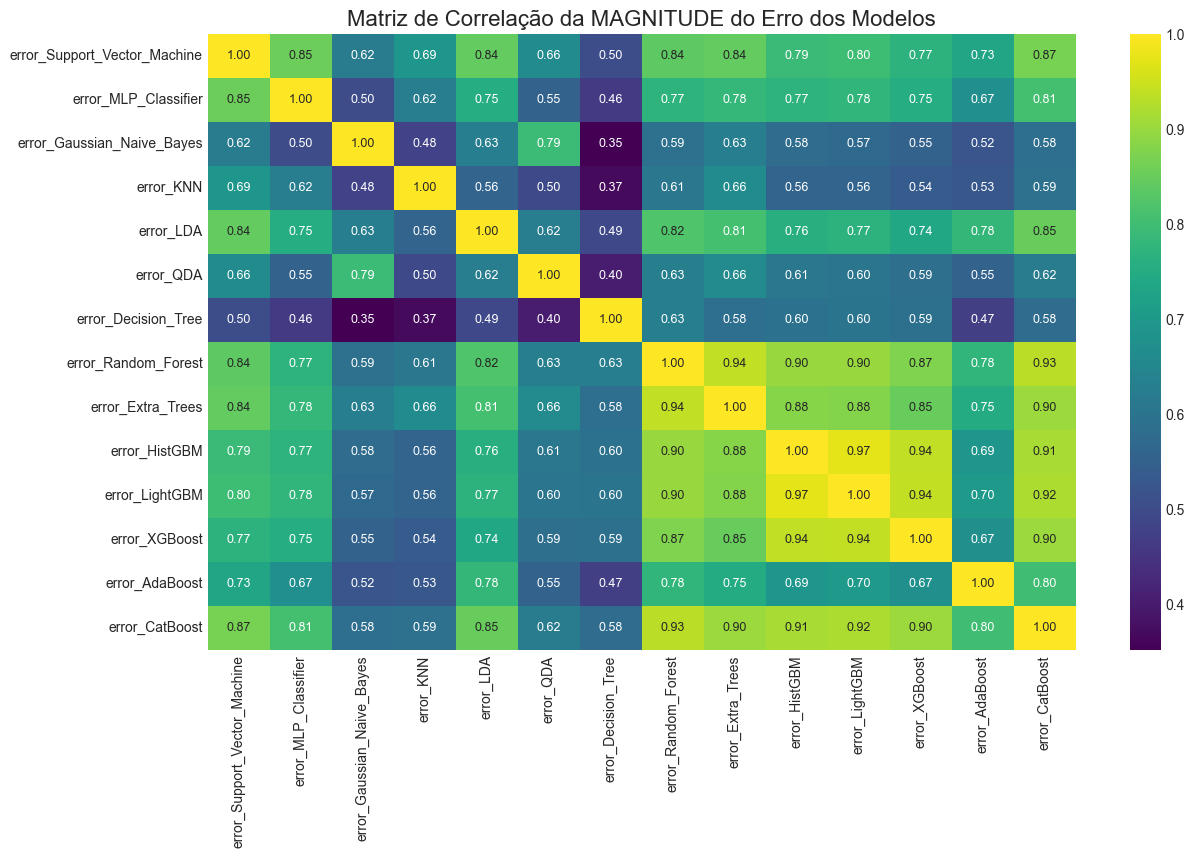

In [ ]:
error_magnitude_df = pd.DataFrame()
all_model_names = list(models_sensitive_to_distribution.keys()) + list(models_robust_to_distribution.keys())
y_true_numeric = cv_probabilities_df['y_true'].astype(int)

for name in all_model_names:
    error_col_name = f"error_{name.replace(' ', '_')}"
    error_magnitude_df[error_col_name] = np.abs(cv_probabilities_df[name] - y_true_numeric)

error_correlation = error_magnitude_df.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(error_correlation, annot=True, cmap='viridis', fmt=".2f", annot_kws={"size": 9})
plt.title('Correlation Matrix of MODELS ERROR MAGNITUDE', fontsize=16)
plt.show()

Analyzing the heatmap of the correlation between predicted probabilities and the true value, we clearly observe that some models exhibit very similar behavior. Models such as Random Forest, CatBoost, XGBoost, and AdaBoost show very high correlation with each other, with values ranging from 0.75 to over 0.95, indicating that they share quite similar patterns of confidence and error.

Given this, the ideal strategy is not to choose multiple models from the same architectural group, as this introduces redundancy in the ensemble. Instead, we should seek a balance between individual performance and diversity by selecting models that, in addition to achieving good results in key metrics (such as Recall), also present low correlation between their predictions — which indicates they make different errors and are therefore more complementary.

Thus, the choice of models to compose the stack should consider two main criteria:

- Robust individual performance, prioritizing metrics relevant to the objective (in this case, Recall);
- Predictive diversity, represented by low correlation between the predictions or errors of the models, maximizing the potential gain of the meta-model by combining non-redundant information.


#### Stacking Ensemble

After identifying AdaBoost as the best-performing individual model, we will conduct one final experiment to test whether a Stacking ensemble can extract even more predictive power. Unlike a voting ensemble, the StackingClassifier uses a "meta-model" to intelligently learn how to combine the predictions of a set of base models.

Three base models with fundamentally different architectures were chosen, each with a distinct way of "viewing" the problem:

1. `AdaBoostClassifier`: Represents the power of tree-based boosting models, which excel at capturing complex and non-linear relationships. Additionally, it is particularly effective when features interact subtly, as it iteratively focuses on the hardest-to-classify samples.
2. `QuadraticDiscriminantAnalysis`: Assumes a different covariance matrix for each class, allowing it to model curved decision boundaries and non-linear relationships.
3. `SVC` (Support Vector Classifier): Represents maximum-margin models that build an optimal boundary to separate classes. It is effective at identifying non-linear patterns and complex relationships between variables, even in high-dimensional spaces.

The above models have a lower combination of error correlations compared to others (as can be seen in the heatmap).

The hypothesis is that by combining the distinct "opinions" of these three models, a meta-model (LogisticRegression) can learn to weigh their strengths and weaknesses, correcting each one's individual errors and resulting in a final classifier that is more robust and has greater detection power (Recall).


In [ ]:
pipeline_ada = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer(drop_weak_features=True)),
    ('scaler', StandardScaler()),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42))
])

pipeline_qda = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('dynamic_preprocessor', DynamicPreprocessor()),
    ('resampling', ADASYN(random_state=42)),
    ("classifier", QuadraticDiscriminantAnalysis())
])

pipeline_svc = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer(drop_weak_features=True)),
    ('dynamic_preprocessor', DynamicPreprocessor()),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', SVC(probability=True, random_state=42))
])

estimators = [
    ('adaboost', pipeline_ada),
    ('mlp', pipeline_qda),
    ('logistic', pipeline_svc )
]

meta_classifier = LogisticRegression(random_state=42, max_iter=1000)

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=cv_strategy,
    passthrough=False
)

scores = cross_val_score(stacking_model, X_train, y_train, cv=cv_strategy, scoring='recall')

print(f"Mean Recall (CV=5): {np.mean(scores):.4f}")  
print(f"Standard Deviation of Scores: {np.std(scores):.4f}")
print("---" * 20)
print(f"Mean Recall of the Best Individual Model (AdaBoost) (CV=5): {results_df['Mean_Recall'][0]:.4f}")  
print(f"Standard Deviation of Scores of the Best Individual Model (AdaBoost): {results_df['Standard_Deviation'][0]:.4f}")

Recall Médio (CV=5): 0.8645
Desvio Padrão dos Scores: 0.0196
------------------------------------------------------------
Recall Médio do melhor modelo individualmente (AdaBoost) (CV=5): 0.8804
Desvio Padrão dos Scores do melhor modelo individualmente (AdaBoost): 0.0226


According to the cross-validation results, the `StackingClassifier` (Average Recall: 0.8645) was not able to outperform the best individual model, the `AdaBoostClassifier` (Average Recall: 0.8804).

The reason why a more complex ensemble did not outperform the individual model is usually due to a main factor:
- The main base model (in this case, AdaBoost) is already extremely powerful and well-tuned to the problem. After the robust feature engineering we performed, AdaBoost was able to capture the vast majority of predictive patterns, leaving little "residual information" or "correctable errors" for the other models to contribute significantly. The meta-model's attempt to combine predictions, in this scenario, ended up introducing more noise than signal, resulting in slightly worse performance.

Therefore, our experimentation and validation confirm that, for this problem and with this set of features, the final pipeline using the `AdaBoostClassifier` model individually is the best performing solution and the recommended one for implementation.


## Hyperparameter Tuning

After the experimentation phase identified the `AdaBoostClassifier` as the highest performing model for our objective, the final step is to perform a "fine tuning" of its main hyperparameters. The goal of this stage is to extract the maximum predictive power from the algorithm by finding the configuration that best fits the structure of our data.

For this, we will employ an advanced optimization strategy:

- **Technique**: Bayesian Search (`BayesSearchCV`). Unlike a grid search that tests all combinations, the Bayesian approach is more efficient, using results from past iterations to "learn" and focus the search on more promising regions of the hyperparameter space.
- **Optimization Metric**: The process will be guided to maximize the **Recall** of the `Dropout` class. This decision is made to align the model with the business objective of minimizing the number of False Negatives, ensuring that the highest possible number of at-risk students are identified.
- **Target Hyperparameters**: The optimization will focus on the most influential parameters of AdaBoost:
    - `n_estimators`: The number of decision trees composing the ensemble.
    - `learning_rate`: The learning rate, which controls the weight each tree has in correcting errors from the previous one.
    - `estimator__max_depth`: The maximum depth of each base decision tree, controlling the model's complexity.


In [ ]:
if os.path.exists('./best_adaboost.pkl'):
    best_adaboost_pipeline = joblib.load('best_adaboost.pkl')
else:
    base_estimator = DecisionTreeClassifier(class_weight='balanced', random_state=42)

    ada_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

    search_space_adaboost = {
        'classifier__n_estimators': Integer(50, 1000),
        'classifier__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'classifier__estimator__max_depth': Integer(1, 5)
    }

    full_pipeline_ada = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('scaler', StandardScaler()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', ada_model)
    ])

    optimizer_ada = BayesSearchCV(
        estimator=full_pipeline_ada,
        search_spaces=search_space_adaboost,
        n_iter=96,
        cv=cv_strategy,
        scoring='recall',
        random_state=42,
        verbose=0
    )

    optimizer_ada.fit(X_train, y_train)
    best_adaboost_pipeline = optimizer_ada.best_estimator_
    joblib.dump(best_adaboost_pipeline, 'best_adaboost.pkl')
    
    print(f"Best Recall (cross-val): {optimizer_ada.best_score_:.4f}")
    print("Best Hyperparameters found:")
    for param, value in optimizer_ada.best_params_.items():
        print(f"  - {param}: {value}")

In [24]:
set_config(display='diagram')
best_adaboost_pipeline

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=2,
                                                                     random_state=42),
                                    learning_rate=0.0432315460587612,
                                    n_estimators=861, random_state=42))])

Best Hyperparameters Found:

- `n_estimators`: 861
- `learning_rate`: 0.0432
- `estimator__max_depth`: 2


The parameter combination found reveals the profile of a high-performance boosting model:

1. **Gradual and Cautious Learning**: The search found a classic combination of a low learning rate (`learning_rate=0.043`) with a high number of estimators (`n_estimators=861`). This indicates that the ideal model learns incrementally, where each new tree makes only small corrections to the errors of the previous one. This approach tends to produce more robust models with better generalization capability, avoiding abrupt adjustments and overfitting.

2. **Controlled Complexity**: The optimizer preferred base trees with depth `max_depth=2` instead of `max_depth=1` (the default). This allows the model to capture simple interactions between two features, giving it a bit more predictive power than the standard "decision stumps," but without risking creating overly complex trees that might not generalize well.

### Model Importance Analysis

In [25]:
final_model_pipeline = best_adaboost_pipeline.fit(X_train, y_train)
feature_engineer_trained = final_model_pipeline.named_steps['feature_engineer']
scaler_trained = final_model_pipeline.named_steps['scaler']

X_train_feature_engineer = feature_engineer_trained.transform(X_train)
X_train_scaled = scaler_trained.transform(X_train_feature_engineer)
classifier_trained = final_model_pipeline.named_steps['classifier']

feature_names = X_train_feature_engineer.columns

X_train_enriched = pd.DataFrame(X_train_scaled, index=X_train_feature_engineer.index, columns=feature_names)
X_train_enriched.head()

,Application order,Curricular units 1st sem (credited),Curricular units 1st sem (evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (evaluations),Unemployment rate,Inflation rate,GDP,nivel_educacional_pais,indice_estresse_financeiro,...,interacao_curso_genero_encoded,Daytime/evening attendance_1,Displaced_1,Debtor_1,Tuition fees up to date_1,Gender_1,Scholarship holder_1,faixa_etaria_Maduro_Senior,faixa_etaria_Tradicional_Adulto,faixa_etaria_Tradicional_Jovem
1232,-0.554948,0.084281,-0.027948,0.191807,0.049002,-1.499431,0.985749,0.151859,0.665067,0.021354,...,-1.293047,0.355605,0.910971,-0.36415,0.392115,-0.720849,-0.60281,-0.244651,1.575441,-0.897133
1545,-0.554948,-0.307952,0.433191,-0.291287,-0.450300,-1.499431,0.985749,0.151859,-0.076183,0.021354,...,-0.881250,0.355605,0.910971,-0.36415,0.392115,-0.720849,-0.60281,-0.244651,-0.634743,1.114662
2070,-0.554948,-0.307952,-0.258517,-0.291287,0.548303,-1.016164,0.121585,1.563457,-0.076183,0.021354,...,-0.233426,0.355605,0.910971,-0.36415,0.392115,-0.720849,-0.60281,-0.244651,-0.634743,1.114662
230,0.196366,-0.307952,0.433191,-0.291287,-0.450300,0.396463,1.777899,-0.742006,-0.076183,0.021354,...,-0.066601,0.355605,0.910971,-0.36415,0.392115,-0.720849,-0.60281,-0.244651,-0.634743,1.114662
575,-0.554948,-0.307952,0.894329,-0.291287,0.049002,-0.830292,-1.462715,-1.370366,-1.558682,1.340731,...,1.054441,0.355605,0.910971,-0.36415,-2.550270,1.387253,-0.60281,-0.244651,-0.634743,-0.897133


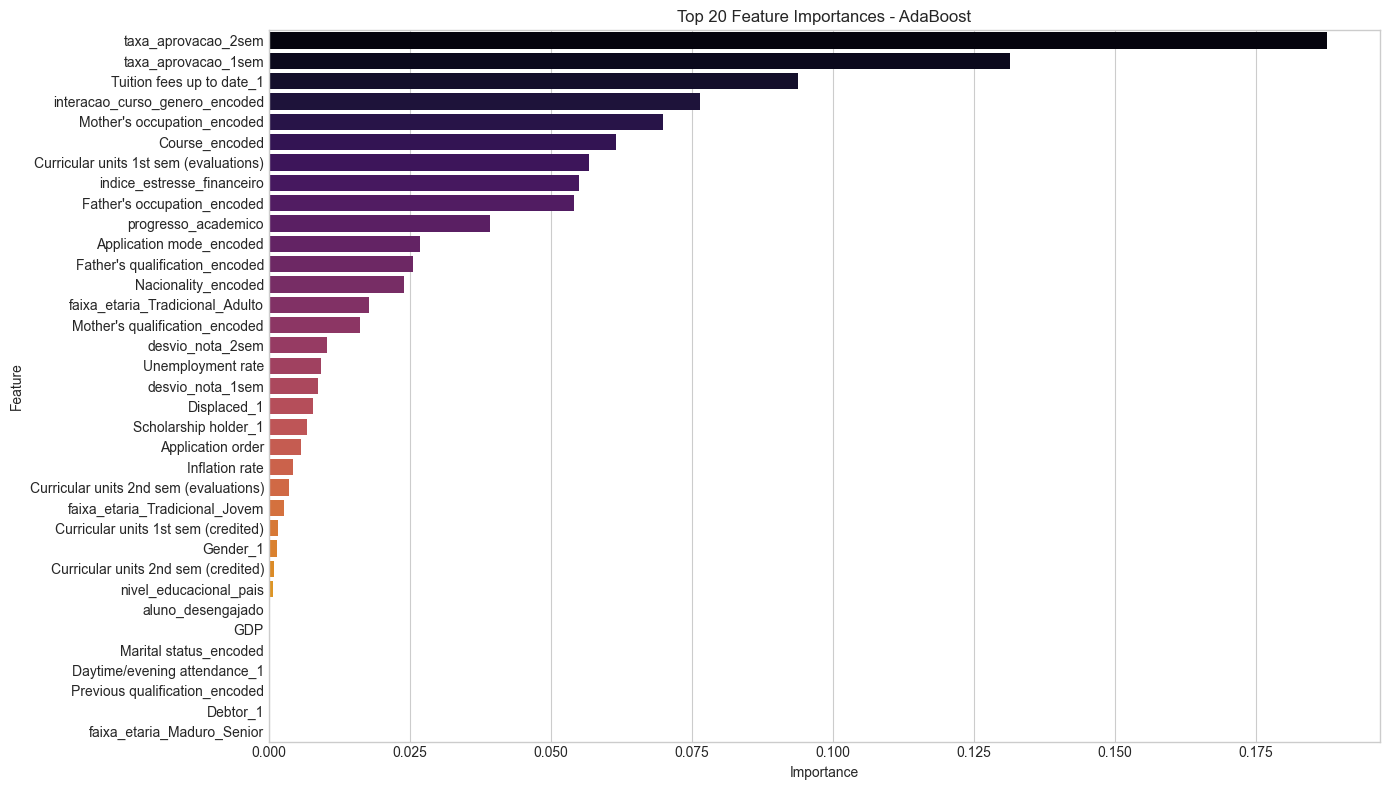

In [ ]:
importances_gini = classifier_trained.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_gini
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(data=feature_importance_df.head(20), x='importance', y='feature', palette='inferno')
plt.title('Top 20 Feature Importances - AdaBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

 93%|=================== | 5409/5808 [00:13<00:00]       

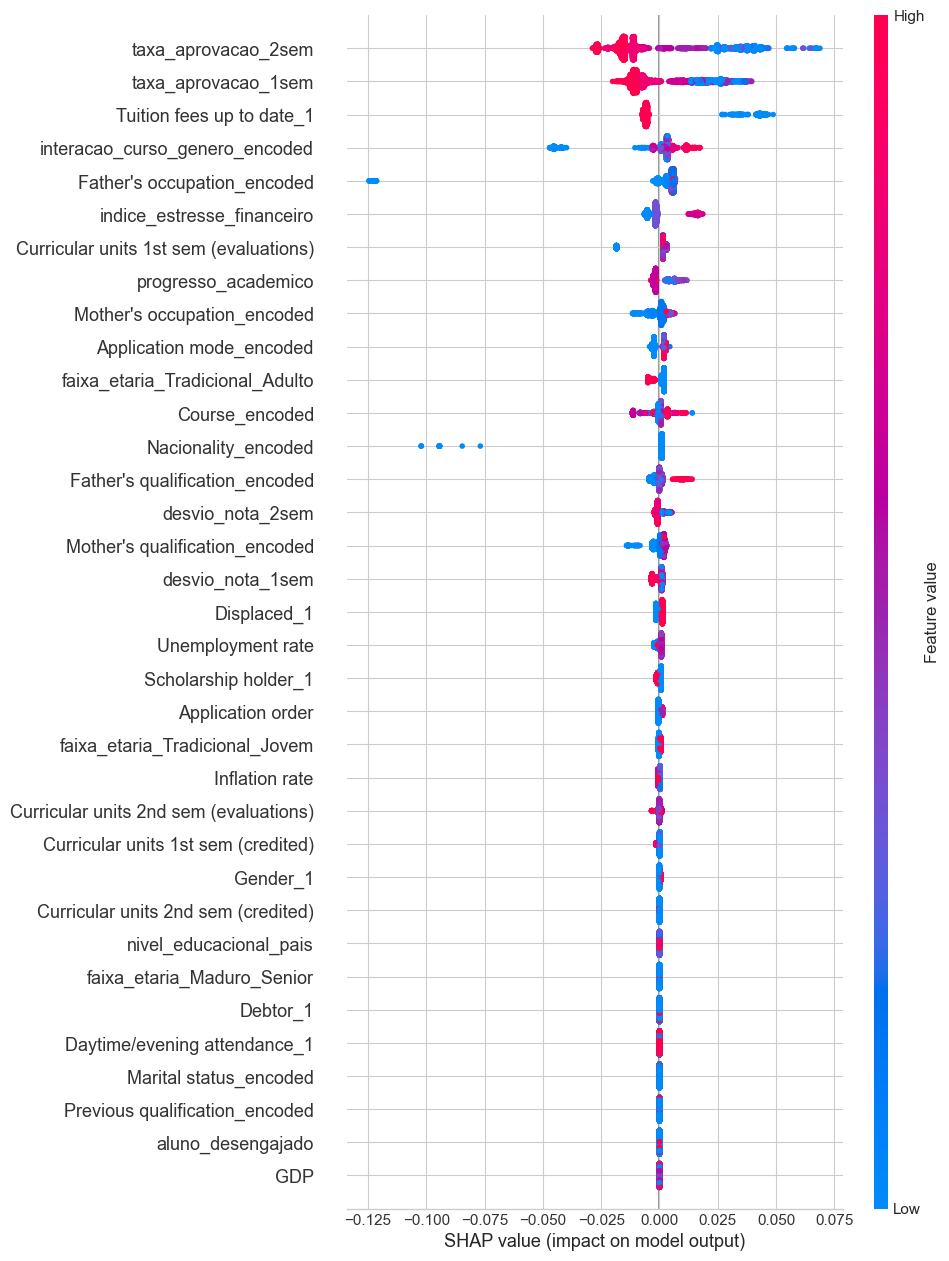

In [27]:
explainer = shap.Explainer(classifier_trained, X_train_enriched)
shap_values = explainer(X_train_enriched)

shap.plots.beeswarm(shap_values[:, :, 1], max_display=35)

In [ ]:
importance_shap = shap_values.abs.mean(axis=0).values.mean(axis=1)
features_shap = X_train_enriched.columns[importance_shap > 0.002].tolist()  # Removing no-impact features
features_gini = feature_importance_df[feature_importance_df['importance'] > 0]['feature'].tolist()

gini_only_features = set(features_gini) - set(features_shap)

print(f"Total important features for Gini: {len(features_gini)}")
print(f"Total important features for SHAP: {len(features_shap)}")
print("-" * 50)
print(f"Features important ONLY for Gini (candidates for removal):")
pprint(list(gini_only_features))

Total de features importantes para Gini: 28
Total de features importantes para SHAP: 12
--------------------------------------------------
Features importantes APENAS para o Gini (candidatas à remoção):
['Curricular units 1st sem (credited)',
 'Curricular units 2nd sem (credited)',
 "Mother's qualification_encoded",
 'Scholarship holder_1',
 'nivel_educacional_pais',
 'Displaced_1',
 'Application order',
 "Father's qualification_encoded",
 'Inflation rate',
 'desvio_nota_2sem',
 'Curricular units 2nd sem (evaluations)',
 'faixa_etaria_Tradicional_Jovem',
 'Nacionality_encoded',
 'Unemployment rate',
 'Gender_1',
 'desvio_nota_1sem']


Comparing Gini vs. SHAP: Why the Difference?

- **Gini Importance** (`.feature_importances_`): Measures how frequently and effectively a feature was used to create pure "nodes" during the construction of decision trees. It can assign a small but non-zero importance value to features that were used at some point, even if their final impact on the prediction is minimal.
- **SHAP Importance** (Mean Absolute Value): Measures the actual impact of a feature on the model’s final output. If a feature is used in a tree but its effect is canceled out by other trees in the ensemble, its average SHAP value can be zero.

**Key Takeaway**: SHAP is considered a more reliable and true metric of a feature’s predictive importance. The fact that it identified a smaller set (16 features) suggests that the other 12 features, although used in model construction, have a negligible or zero net impact on the final predictions.


In [ ]:
pipeline_shap = ImblearnPipeline(steps=[
    ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
    ('feature_selector', ColumnTransformer(
        transformers=[
            ("selector", "passthrough", features_shap)
        ], 
        remainder='drop'
    )),
    ('scaler', StandardScaler()),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            class_weight=classifier_trained.estimator.class_weight,
            max_depth=classifier_trained.estimator.max_depth,
            random_state=42
        ),
        learning_rate=classifier_trained.learning_rate,
        n_estimators=classifier_trained.n_estimators,
        random_state=42
    ))
])

y_pred_shap = cross_val_predict(
    pipeline_shap,
    X_train,
    y_train,
    cv=cv_strategy
)

y_pred_default = cross_val_predict(
    best_adaboost_pipeline,
    X_train,
    y_train,
    cv=cv_strategy
)

display(pd.DataFrame(classification_report(y_train, y_pred_shap, digits=3, output_dict=True)).T.rename(index={'0': 'graduate','1': 'dropout'}))
print('----'*20)
display(pd.DataFrame(classification_report(y_train, y_pred_default, digits=3, output_dict=True)).T.rename(index={'0': 'graduate','1': 'dropout'}))

,precision,recall,f1-score,support
graduate,0.933174,0.885116,0.908510,1767.000000
dropout,0.834691,0.901495,0.866808,1137.000000
accuracy,0.891529,0.891529,0.891529,0.891529
macro avg,0.883932,0.893306,0.887659,2904.000000
weighted avg,0.894615,0.891529,0.892182,2904.000000


--------------------------------------------------------------------------------


,precision,recall,f1-score,support
graduate,0.929287,0.892473,0.910508,1767.000000
dropout,0.842585,0.894459,0.867747,1137.000000
accuracy,0.893251,0.893251,0.893251,0.893251
macro avg,0.885936,0.893466,0.889128,2904.000000
weighted avg,0.895341,0.893251,0.893766,2904.000000


It was possible to create a simpler and more efficient model (the `pipeline_shap`, which uses fewer features) that:

1. Slightly improved (0.7%) the most important metric for the business problem: **Recall**. In other words, it can identify an even higher percentage of at-risk students.
2. Maintained virtually identical performance in **F1-Score** and **Accuracy**. The 0.1% difference is statistically insignificant and falls within the margin of variation of cross-validation.


In Machine Learning, there is a fundamental principle known as **Ockham’s Razor**: among hypotheses (or models) with similar predictive power, the simplest is almost always the best.

Simpler models are preferable because they are:

- **Faster**: Require less time to train and to make predictions.
- **Easier to Maintain**: Have fewer dependencies on input features, making them more robust in a production environment.
- **Less Prone to Overfitting**: By removing features with low predictive power, we reduce the chance that the model learns "noise" in the training data.

## Final Metrics Comparison

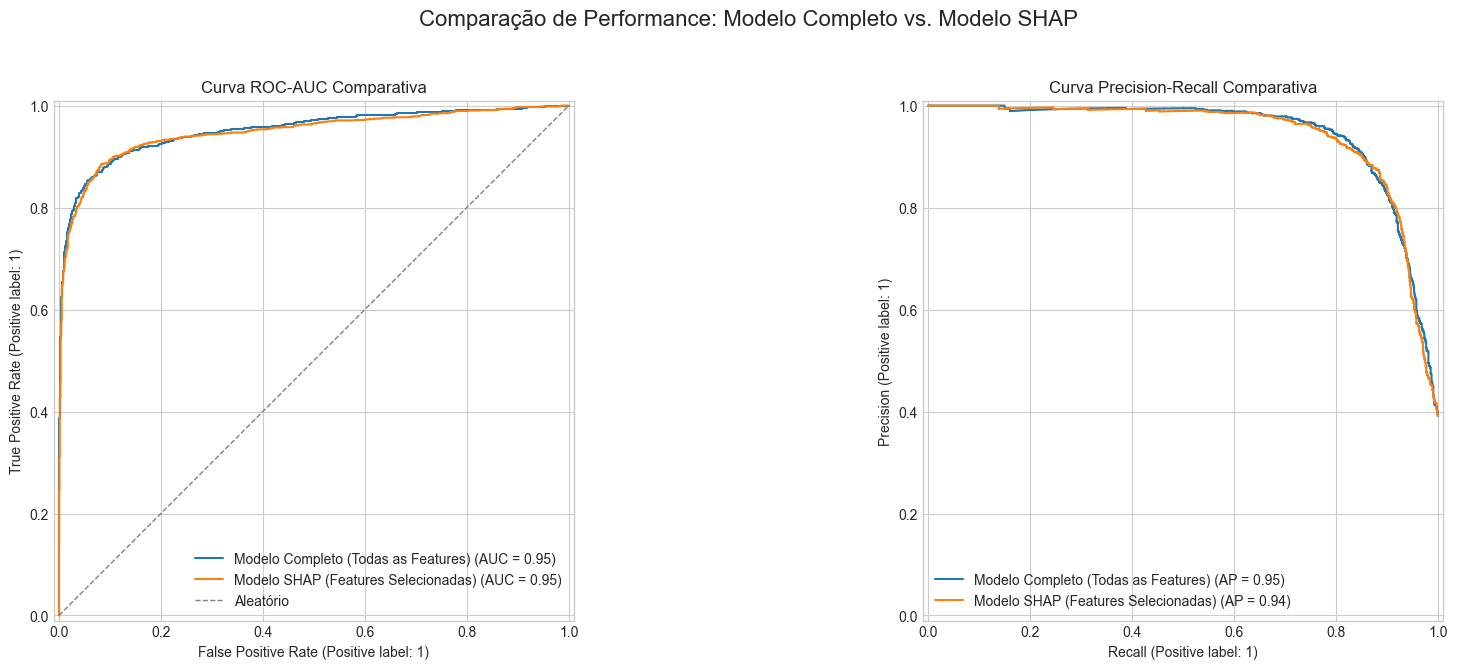

In [ ]:
y_probas_shap = cross_val_predict(
    pipeline_shap, 
    X_train, 
    y_train, 
    cv=cv_strategy, 
    method='predict_proba',
)

y_probas_default = cross_val_predict(
    best_adaboost_pipeline, 
    X_train, 
    y_train, 
    cv=cv_strategy, 
    method='predict_proba',
)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Performance Comparison: Full Model vs. SHAP Model', fontsize=16)

RocCurveDisplay.from_predictions(
    y_train, 
    y_probas_default[:, 1],
    ax=axes[0], 
    name="Full Model (All Features)"
)

RocCurveDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    ax=axes[0], 
    name="SHAP Model (Selected Features)"
)
axes[0].plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random')
axes[0].set_title("Comparative ROC-AUC Curve")
axes[0].legend()

PrecisionRecallDisplay.from_predictions(
    y_train, 
    y_probas_default[:, 1], 
    ax=axes[1], 
    name="Full Model (All Features)"
)

PrecisionRecallDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    ax=axes[1], 
    name="SHAP Model (Selected Features)"
)
axes[1].set_title("Comparative Precision-Recall Curve")
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- **ROC-AUC Curve (The Technical Tie)**:
    - The AUC measures the model’s overall ability to distinguish a student who will drop out from one who will graduate. An identical result means the fundamental discrimination power of both models is exactly the same. The 12 extra features used by the full model do not add any overall separation power between the classes.

- **Precision-Recall Curve (The Marginal Advantage)**:
    - This is where we see the only, and very small, advantage of the full model (AP = 0.95 vs 0.94). The Area Under the Precision-Recall Curve (AP) is more sensitive in imbalanced datasets. This 0.01 difference tells us that the full model, across all decision thresholds, manages to maintain slightly higher precision for different levels of recall. The 12 extra features, although not improving overall separation, offer a small help in refining probabilities and avoiding some False Positives.

Is it worth keeping a more complex model, with more features and higher maintenance costs, for a 1% improvement in a single metric when another main metric (ROC AUC) shows they are identical?

No, because:

1. **Statistically Equivalent Performance**: The 1% difference in AP is marginal and most likely not statistically significant. The overall discrimination power is identical. You are not sacrificing real performance.

2. **The Cost of Complexity**: The simpler model (with 16 features) is objectively better than the complex one (with 28+ features) in all operational aspects: it is faster to train, faster to make predictions, cheaper to host, easier to maintain, and easier to explain.

3. **Principle of Parsimony (Ockham’s Razor)**: Between two models with virtually equal predictive power, always choose the simpler one. It is more robust, more generalizable, and less likely to have learned noise specific to the training data.

**Conclusion**: We will use the model with fewer features for the final predictions and evaluations.

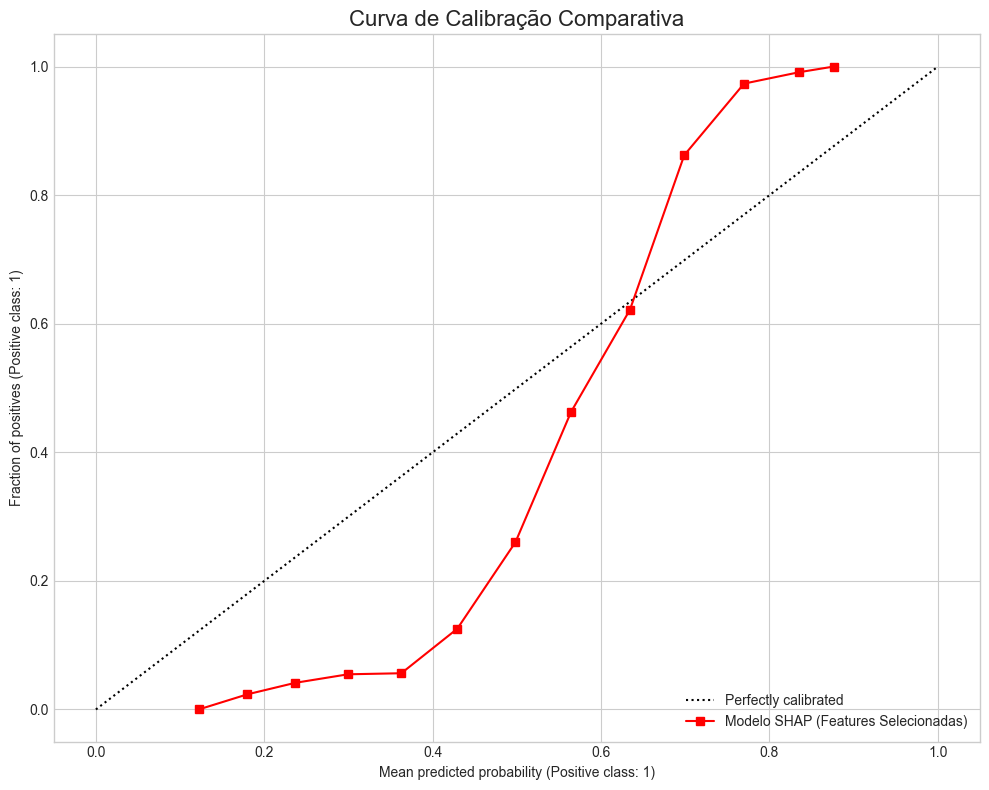

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    n_bins=15,
    ax=ax,
    name="SHAP Model (Selected Features)",
    color='red'
)

ax.set_title("Comparative Calibration Curve", fontsize=16)
plt.tight_layout()
plt.show()

The graph, with its "S" shape, provides two very important business insights about the AdaBoost model:

- **Confidence at the Extremes**: The model is excellent at identifying the extremes.
    - **Low Risk**: When it predicts a low probability (e.g., 20%), the actual dropout chance is even lower (almost 0%). This means you can fully trust that students classified as low risk are indeed safe.
    - **High Risk**: When it predicts a high probability (e.g., 80%), the actual dropout chance is even higher (almost 100%). This means that students at the top of the risk list are certainly the most critical cases.

When should we calibrate our model?

- **Objective**: If the business goal is "to create an intervention program with different levels of intensity. We need to know which students have more than an 80% chance of dropping out for individual tutoring, which are between 60-80% for a group workshop, and which are between 50-60% to receive a support email," then **calibration is essential**.

- **Justification**: To create these ranges and make business decisions based on them, you need to trust that an "80%" prediction actually corresponds to a real-world probability close to 80%. An uncalibrated model is overconfident; it may give a 60% probability for a student whose true dropout chance is only 30%. Using it to create risk bands would lead to a completely misguided allocation of resources.

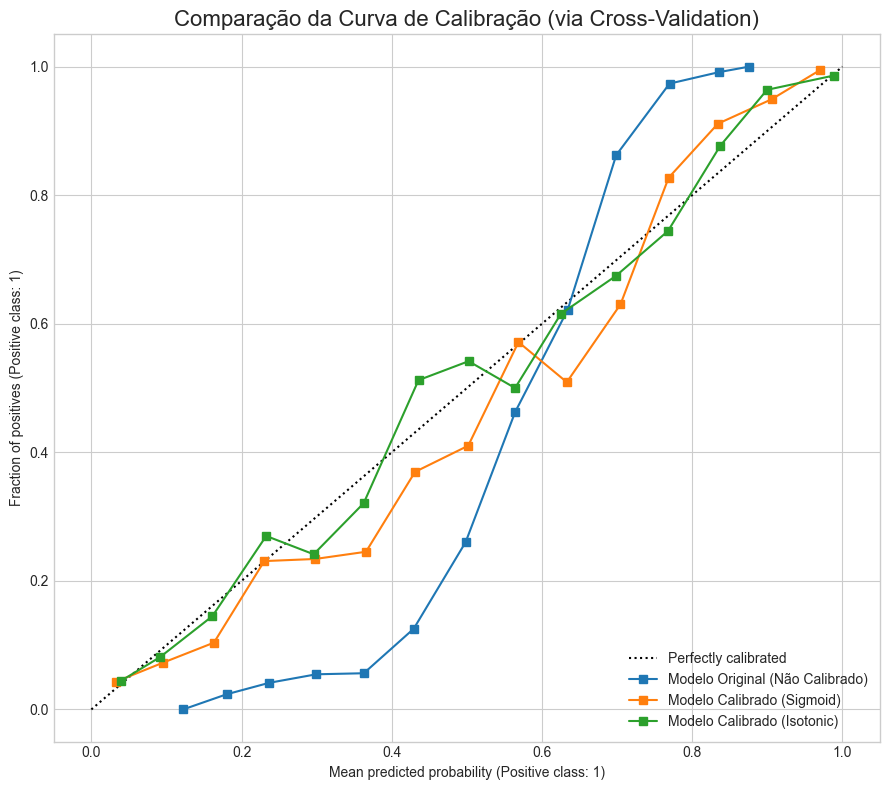

In [ ]:
calibrated_sigmoid_pipeline_cv = CalibratedClassifierCV(
    pipeline_shap, 
    method='sigmoid', 
    cv=cv_strategy
)

calibrated_isotonic_pipeline_cv = CalibratedClassifierCV(
    pipeline_shap, 
    method='isotonic', 
    cv=cv_strategy
)

y_probas_sigmoid_calibrated_cv = cross_val_predict(
    calibrated_sigmoid_pipeline_cv,
    X_train,
    y_train,
    cv=cv_strategy,
    method='predict_proba',
)

y_probas_isotonic_calibrated_cv = cross_val_predict(
    calibrated_isotonic_pipeline_cv,
    X_train,
    y_train,
    cv=cv_strategy,
    method='predict_proba',
)

fig, ax = plt.subplots(figsize=(9, 8))

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1],
    n_bins=15, 
    ax=ax,
    name="Original Model (Uncalibrated)",
)

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_sigmoid_calibrated_cv[:, 1], 
    n_bins=15,
    ax=ax,
    name="Calibrated Model (Sigmoid)",
)

CalibrationDisplay.from_predictions(
    y_train,
    y_probas_isotonic_calibrated_cv[:, 1], 
    n_bins=15,
    ax=ax,
    name="Calibrated Model (Isotonic)",
)

ax.set_title("Calibration Curve Comparison (via Cross-Validation)", fontsize=16)
plt.tight_layout()
plt.show()


- **Original Model (Blue Curve)**: Confirms what we already knew. The base model is a great classifier (it orders students well by risk), but a poor probability estimator due to its overconfidence, with a sharply "S"-shaped curve.

- **Calibrated Model (Sigmoid - Orange Curve)**: We see a significant improvement. Sigmoid calibration (also known as Platt Scaling) did a great job of "smoothing" the model's overconfidence, bringing the curve much closer to the ideal diagonal line.

- **Calibrated Model (Isotonic - Green Curve)**: This is the winner. The isotonic regression curve, being more flexible and not assuming a specific form, was able to fit the data almost perfectly. Across virtually all probability ranges, the calibrated model’s prediction matches reality. The small "zigzag" is normal for this method, as it fits the data in a piecewise manner.

With calibration, we can transform the model from a binary classifier into a risk management system.

With probabilities calibrated using the isotonic method, the educational institution can, with high confidence, implement intervention strategies based on risk bands (e.g., High Risk > 80%, Medium Risk 60-80%), knowing that these numbers faithfully correspond to reality. This optimizes resources, personalizes the approach, and maximizes the impact of retention actions.

## Final Evaluations (Test Data)

#### Comparison Between the Calibrated (Isotonic) and Non-Calibrated Model

Processando: AdaBoost (Não Calibrado)...
Processando: AdaBoost (Calibrado Isotonic)...


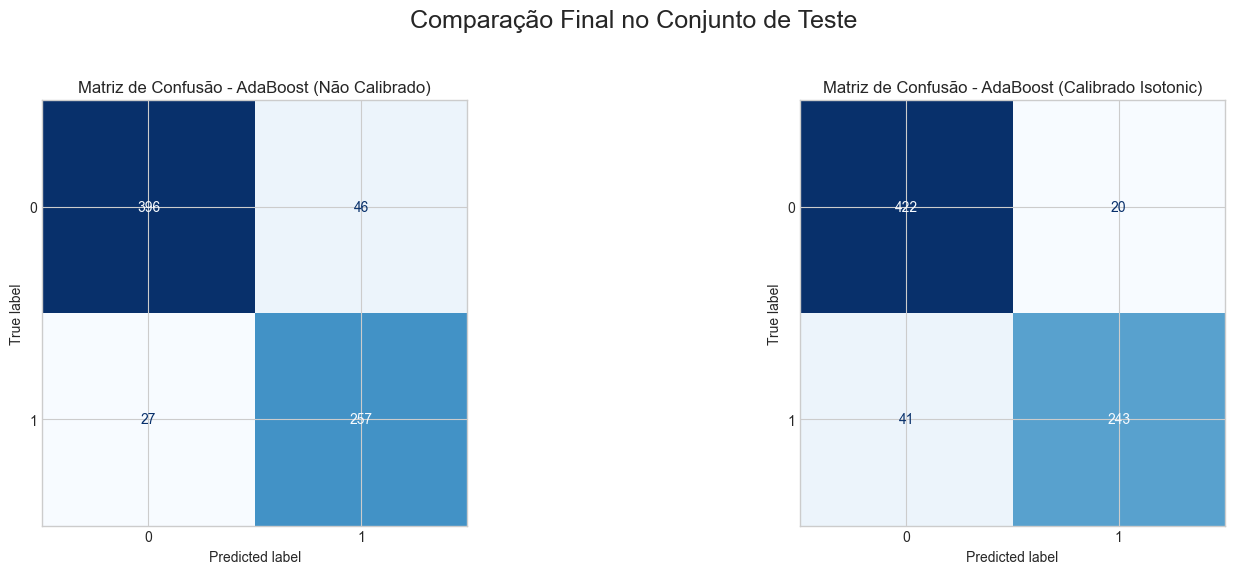


--- Tabela Comparativa de Performance Final ---


,Precisão (Dropout),Recall (Dropout),F1-Score (Dropout)
AdaBoost (Não Calibrado),0.8482,0.9049,0.8756
AdaBoost (Calibrado Isotonic),0.9240,0.8556,0.8885


In [ ]:
pipelines_to_compare = {
    "AdaBoost (Uncalibrated)": pipeline_shap,
    "AdaBoost (Isotonic Calibrated)": calibrated_isotonic_pipeline_cv
}

final_results = {}
fitted_pipelines = {}

for name, pipeline in pipelines_to_compare.items():
    print(f"Processing: {name}...")
    
    fitted_model = pipeline.fit(X_train, y_train)
    fitted_pipelines[name] = fitted_model
    
    y_pred = fitted_model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    dropout_metrics = report.get('1', {})
    
    final_results[name] = {
        'Precision (Dropout)': dropout_metrics.get('precision', 0),
        'Recall (Dropout)': dropout_metrics.get('recall', 0),
        'F1-Score (Dropout)': dropout_metrics.get('f1-score', 0)
    }

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Final Comparison on Test Set', fontsize=18)

for i, (name, pipeline) in enumerate(fitted_pipelines.items()):
    ax = axes[i]
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Confusion Matrix - {name}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

results_df = pd.DataFrame.from_dict(final_results, orient='index')
results_df = results_df.round(4)

print("\n--- Final Performance Comparison Table ---")
display(results_df)

The result is a classic trade-off:

| Metric / Feature                  | Non-Calibrated Model           | Calibrated Model (Isotonic)   |
|---------------------------------|-------------------------------|-------------------------------|
| Recall (Detection)               | **0.9049 (Superior)**          | 0.8556                        |
| Precision (Efficiency)           | 0.8482                        | **0.924 (Superior)**          |
| F1-Score (Balance)               | 0.856                         | **0.8885 (Slightly Superior)**|
| Probability Reliability          | Low (Overconfident)            | **High (Realistic)**          |

- The **Non-Calibrated** Model is our best "safety net." It is superior at finding the highest possible number of at-risk students (**Higher Recall**).
- The **Calibrated** Model is our "high-efficiency" tool. It generates far fewer false alarms, ensuring that the support team’s time is better utilized (**Higher Precision**).

##### Application Scenarios: Which Model for Which Strategy?

The choice between the two models is not technical, but a business decision based on the institution’s resources and philosophy.

- **Scenario A**: "Ranking Strategy and Maximum Reach" - Choosing the Non-Calibrated Model
    - **When to use**: If the institution’s main goal is simply to generate an ordered list of students at highest risk so that a support team can contact them sequentially, from most to least likely.
    - **How it works**: In this scenario, the exact probability value is less important than the ranking it produces. The non-calibrated model, with its superior Recall of nearly 91%, is the best tool to ensure the "safety net" is as large as possible, capturing the maximum number of students who need help.
    - **Advantage**: Maximum detection of at-risk cases.
    - **Disadvantage**: The support team will deal with more "false alarms" (precision of 86%), and it won’t be possible to differentiate a student with "high risk" from one with "extreme risk" based on probability.

- **Scenario B**: "Risk Management by Levels Strategy" - Choosing the Calibrated Model
    - **When to use**: If the institution wants to create a sophisticated, segmented intervention strategy based on urgency levels, allocating resources more intelligently.
    - **How it works**: With the reliable and realistic probabilities from the calibrated model, the institution can safely create action bands:
        - **Critical Risk (Probability > 80%)**: Immediate and personal intervention by a senior counselor.
        - **High Risk (Probability 60-80%)**: Invitation to a support workshop or group tutoring.
        - **Moderate Risk (Probability 50-60%)**: Sending an informative email with resources and help channels.
    - **Advantage**: This approach is much more efficient and personalized. It not only predicts but reliably quantifies risk.
    - **Disadvantage**: Accepts that the total "safety net" is somewhat smaller (Recall of 85%), which can have a significant impact since false negatives may cause financial consequences for the educational institution.

##### Conclusion:

After analyzing the performance of the final models on the test set, the (likely) decision of an educational institution would be to adopt the **Non-Calibrated AdaBoost Model** as the main solution to be implemented. However, the calibrated model can also be incorporated as a secondary alternative, useful in contexts requiring greater reliability in estimated probabilities or where balancing metrics beyond recall is necessary.

This choice is based on the premise that the highest priority for an educational institution is maximizing the detection of at-risk students, making **Recall** the fundamental metric. In this context, the goal of avoiding **False Negatives** (missing an at-risk student) is considered more critical than preventing **False Positives** (intervening with a student who did not need it) and/or having perfectly calibrated probabilities, which are secondary objectives. If these secondary objectives become primary, the institution should consider using the calibrated model as the priority alternative.

The non-calibrated model proved to be the most effective tool for this primary mission, achieving a Recall of **90.9%** for the `Dropout` class, outperforming the calibrated version. Although the calibrated model offers higher precision, the choice of the non-calibrated model is justified by its superior ability to create the largest possible "safety net," offering an opportunity to help almost 91% of students who would drop out.

Therefore, the recommended main model is the one that prioritizes reach and detection, directly aligning with a proactive, high-impact student retention strategy. The calibrated model can be maintained as a complementary tool, especially valuable in scenarios where greater reliability in risk estimates is desired.

In [ ]:
final_model = pipelines_to_compare["AdaBoost (Uncalibrated)"]
final_model

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('feature_selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['Curricular units 1st sem '
                                                   '(evaluations)',
                                                   'indice_estresse_financeiro',
                                                   'taxa_aprovacao_1sem',
                                                   'taxa_aprovacao_2sem',
                                                   'progresso_academico',
                                                   'Application mode_encoded',
                                                   'Course_encoded',
                                                   "Mother's "
                                                   'occupation_encoded',
                                                   "Father'...
                                                   'interacao_curso_genero_encoded',
                                                   'Tuition fees up to date_1',
                                                   'faixa_etaria_Tradicional_Adulto'])])),
                ('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=2,
                                                                     random_state=42),
                                    learning_rate=0.0432315460587612,
                                    n_estimators=861, random_state=42))])

We will carry out the remaining analyses using the final **Non-Calibrated AdaBoost** model.

### Model Efficiency Analysis

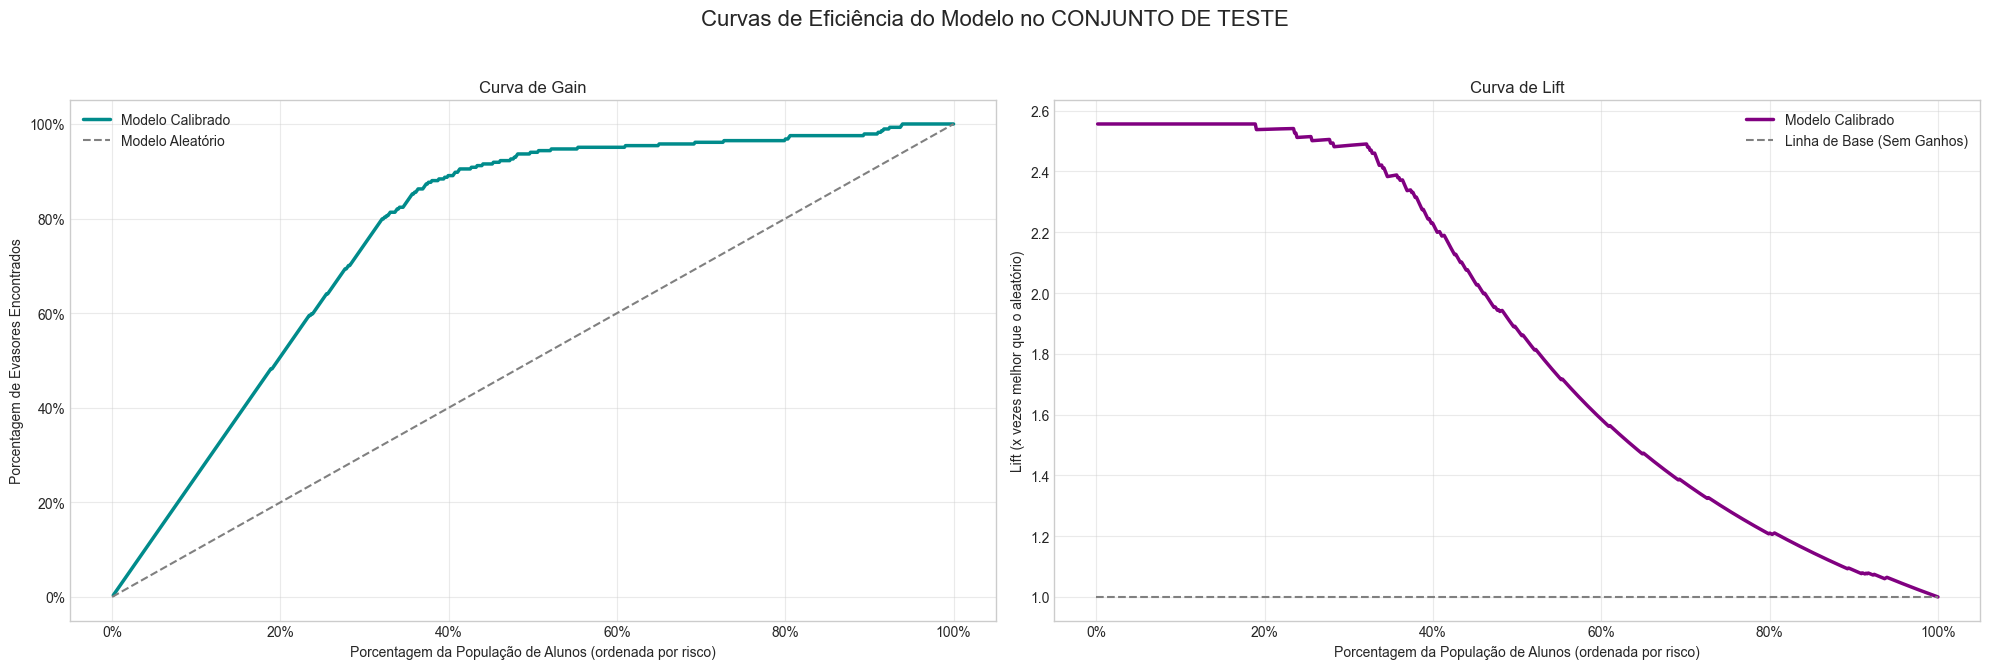

In [ ]:
y_probas_test = final_model.predict_proba(X_test)

y_scores = y_probas_test[:, 1]

df_results_test = pd.DataFrame({'y_true': y_test, 'y_score': y_scores})
df_results_test = df_results_test.sort_values(by='y_score', ascending=False)

df_results_test['cumulative_positives'] = df_results_test['y_true'].astype(int).cumsum()
total_positives = df_results_test['y_true'].astype(int).sum()
df_results_test['gain'] = df_results_test['cumulative_positives'] / total_positives

df_results_test['population_percentage'] = np.arange(1, len(df_results_test) + 1) / len(df_results_test)
df_results_test['lift'] = df_results_test['gain'] / df_results_test['population_percentage']

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Model Efficiency Curves on TEST SET', fontsize=16)

axes[0].plot(df_results_test['population_percentage'], df_results_test['gain'], label='Calibrated Model', color='darkcyan', lw=2.5)
axes[0].plot([0, 1], [0, 1], label='Random Model', color='grey', linestyle='--')
axes[0].set_xlabel("Percentage of Student Population (ordered by risk)")
axes[0].set_ylabel("Percentage of Dropouts Found")
axes[0].set_title('Gain Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.4)
axes[0].xaxis.set_major_formatter(PercentFormatter(1.0))
axes[0].yaxis.set_major_formatter(PercentFormatter(1.0))

axes[1].plot(df_results_test['population_percentage'], df_results_test['lift'], label='Calibrated Model', color='purple', lw=2.5)
axes[1].plot([0, 1], [1, 1], label='Baseline (No Gain)', color='grey', linestyle='--')
axes[1].set_xlabel("Percentage of Student Population (ordered by risk)")
axes[1].set_ylabel("Lift (x times better than random)")
axes[1].set_title('Lift Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.4)
axes[1].xaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Interpretation of the Gain Curve (The "How Much We Find")

The graph on the left shows how quickly the model can find the students who actually belong to the Dropout class.

- **Key Point 1 (Maximum Efficiency)**: By focusing on the 20% of students with the highest risk identified by the model, the institution can find and act on approximately 50% of all students who would drop out.
- **Key Point 2 (Wide Coverage)**: With a slightly greater effort, contacting the top 40% at risk, the support team would already reach about 90% of the target audience (the future dropouts).

**Strategic Insight**: This demonstrates great efficiency. The institution does not need an approach that "shoots everywhere." With a focused effort on less than half of the at-risk student population, it is possible to cover more than 90% of the dropout problem.

#### Interpretation of the Lift Curve (The "How Much Better We Are")

The graph on the right quantifies the model’s power compared to a random approach.

- **Key Point 1 (Initial Lift)**: The initial lift of approximately 2.6 means that a student chosen from the top of the model’s risk list is 2.6 times more likely to be a real dropout than a student randomly chosen from the general population.
- **Key Point 2 (Sustained Lift)**: The lift remains well above 2.0 even when considering 30-40% of the population. This shows that the model is not only good at finding obvious cases but also at efficiently ranking students with moderate risk.

**Strategic Insight**: The model is an "efficiency multiplier" for the support team. Each hour spent contacting students from the model’s list is, on average, 2.5 times more productive than it would be with an undirected approach.

#### Conclusion

Based on these graphs, a manager can decide: "This semester, we have resources to actively intervene with 30% of our students. The model guarantees that by doing so, we will be reaching about 80% of our real dropout problem, which is a great return on investment."

# Model Explainability

We selected the pipeline with the non-calibrated AdaBoost model as the final solution, prioritizing its high detection capability (Recall) of at-risk students. However, a high-performance model has limited value if we cannot trust it or understand how it makes its decisions.

The Explainable AI (XAI) stage is what transforms our model from a "black box" into a "glass box." The goal here is no longer to measure performance, but to answer crucial business questions:

- What are the true drivers of dropout according to the model?
- Can we trust that the model is making logical and fair decisions?
- How can we explain to an academic advisor why a specific student was flagged?

To do this, we will use the SHAP library (SHapley Additive exPlanations), a powerful tool that allows us to quantify the impact of each feature on each individual prediction. SHAP works by treating each model prediction as a "team game," where the features are the "players." It starts from an average prediction (the base value) and then calculates the exact contribution of each feature to bring the final prediction to that specific outcome. A positive SHAP value represents a "push" that increases dropout risk, while a negative SHAP value acts as a protective factor. The color of each point represents the feature value itself: red indicates a high value (e.g., high pass rate) and blue indicates a low value, allowing us to visually see if high values of a feature consistently increase or decrease dropout risk.

Our analysis will follow a "What, How, and Why" narrative:

1. **What? (Global Importance Overview)**: First, we will use the Summary Plot (Beeswarm Plot) to answer: "Which features are, on average, the most important to the model on the test set?" This analysis also serves as a validation of our previous feature selection step, where we already used SHAP values on training data to refine the model. At that stage, features with a mean absolute importance below 0.002 were discarded, allowing us to build a simpler final model focused only on the strongest predictive signals and excluding possible noise. The following plot will therefore confirm if this hierarchy of importance holds on previously unseen data.

2. **How? (Dependence Analysis)**: Next, we will dive deep into the top features with the Dependence Plot. It will help us answer: "How exactly does an important feature (e.g., pass rate) influence dropout risk? Is the relationship linear? Is there an inflection point?"

3. **Why? (Individual Diagnosis)**: Finally, with the Waterfall Plot, we will diagnose an individual case. It will answer: "Why was a specific student classified as high risk?" by breaking down the prediction to understand exactly which factors contributed to the decision.


In [36]:
transformation_pipeline = SklearnPipeline(steps=[
    ('feature_engineer', final_model.named_steps['feature_engineer']),
    ('feature_selector', final_model.named_steps['feature_selector']),
    ('scaler', final_model.named_steps['scaler'])
])

classifier_trained = final_model.named_steps['classifier']

X_train_enriched = transformation_pipeline.transform(X_train)
X_test_enriched = transformation_pipeline.transform(X_test)

X_train_final = pd.DataFrame(X_train_enriched, index=X_train.index, columns=features_shap)

X_test_final = pd.DataFrame(X_test_enriched, index=X_test.index, columns=features_shap)
X_test_final


,Curricular units 1st sem (evaluations),indice_estresse_financeiro,taxa_aprovacao_1sem,taxa_aprovacao_2sem,progresso_academico,Application mode_encoded,Course_encoded,Mother's occupation_encoded,Father's occupation_encoded,interacao_curso_genero_encoded,Tuition fees up to date_1,faixa_etaria_Tradicional_Adulto
1855,-0.489086,1.340731,-1.862718,-1.663068,0.212178,1.719054,0.194290,3.171911,3.256764,0.653369,-2.550270,-0.634743
3638,0.433191,0.021354,0.796004,0.841748,0.212178,-0.886864,-1.265939,-0.382768,-0.413836,-1.293047,0.392115,-0.634743
426,-0.027948,0.021354,0.796004,0.841748,0.212178,-0.886864,0.194290,-0.648246,-0.584035,-0.233426,0.392115,-0.634743
1353,-1.872501,0.021354,-1.862718,-1.663068,0.212178,-0.223871,1.049599,-0.100695,-0.001099,0.919429,0.392115,-0.634743
1853,-0.258517,0.021354,0.796004,0.841748,0.212178,0.280803,0.798371,0.490012,-0.164949,1.082016,0.392115,1.575441
...,...,...,...,...,...,...,...,...,...,...,...,...
2826,-0.489086,-1.298024,0.796004,0.424279,-0.752482,-0.886864,0.194290,-0.100695,-0.584035,-0.233426,0.392115,-0.634743
3685,-0.258517,0.021354,0.796004,0.841748,0.212178,0.322580,0.798371,-0.100695,-0.164949,1.082016,0.392115,1.575441
3021,-0.027948,0.021354,0.416187,0.841748,1.039030,-0.886864,-1.265939,0.490012,-0.560163,-1.293047,0.392115,-0.634743
1902,0.202621,0.021354,0.796004,0.841748,0.212178,-0.886864,1.441630,-0.100695,0.705842,1.005131,0.392115,-0.634743


In [37]:
explainer = shap.Explainer(classifier_trained, X_train_final)
shap_values = explainer(X_test_final)

## What

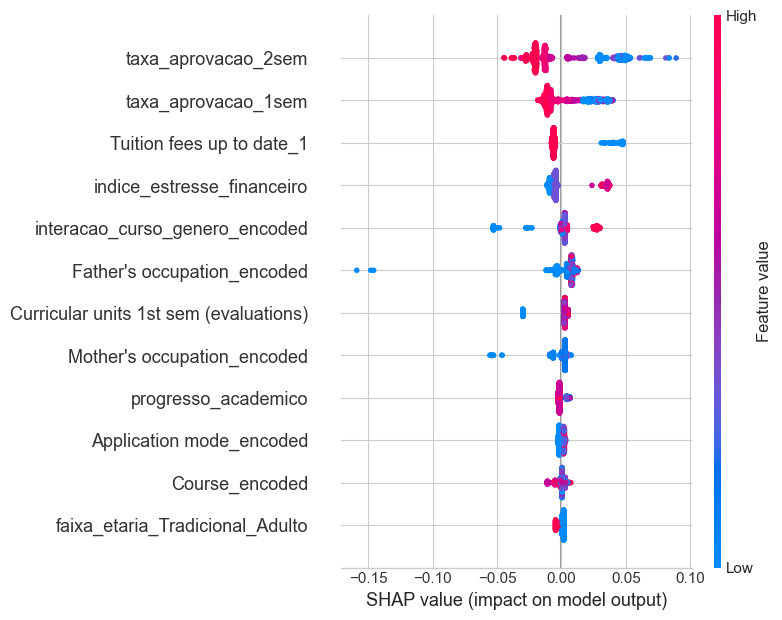

In [38]:
shap.summary_plot(
    shap_values.values[:,:,1],
    X_test_final,
    max_display=20,
    show=False
)

This SHAP summary plot shows the 12 most important features of the final model. The plot reveals which factors, on average, most influence dropout risk in the test set.

The main insights are:

- **Academic Performance is the Most Important Factor**: The two most important features by far are the pass rates for the second and first semesters (`taxa_aprovacao_2sem` and `taxa_aprovacao_1sem`). The plot clearly shows that high values (red) are protective factors (negative SHAP), while low values (blue) significantly increase dropout risk (positive SHAP).

- **Financial Situation is Critical**: Next are tuition status (`Tuition fees up to date_1`) and our custom `indice_estresse_financeiro` as high-impact predictors. Being up to date with payments (red) reduces risk, while having a high financial stress index (red) increases it.

- **Validation of Feature Engineering**: The fact that the features we created (`taxa_aprovacao...`, `indice_estresse_financeiro`, `interacao_curso_genero_encoded`, `progresso_academico`, etc.) dominate the top of the ranking strongly validates that our data transformation work was successful.

- **Model Consistency**: Overall, the plot demonstrates that the model learned the correct relationships: "good" values (high pass rates, payments up to date, low stress) consistently push the prediction toward Graduate (SHAP < 0), and "bad" values push toward Dropout (SHAP > 0). This gives us great confidence that the model is not only accurate but also making decisions for the right reasons.

## How

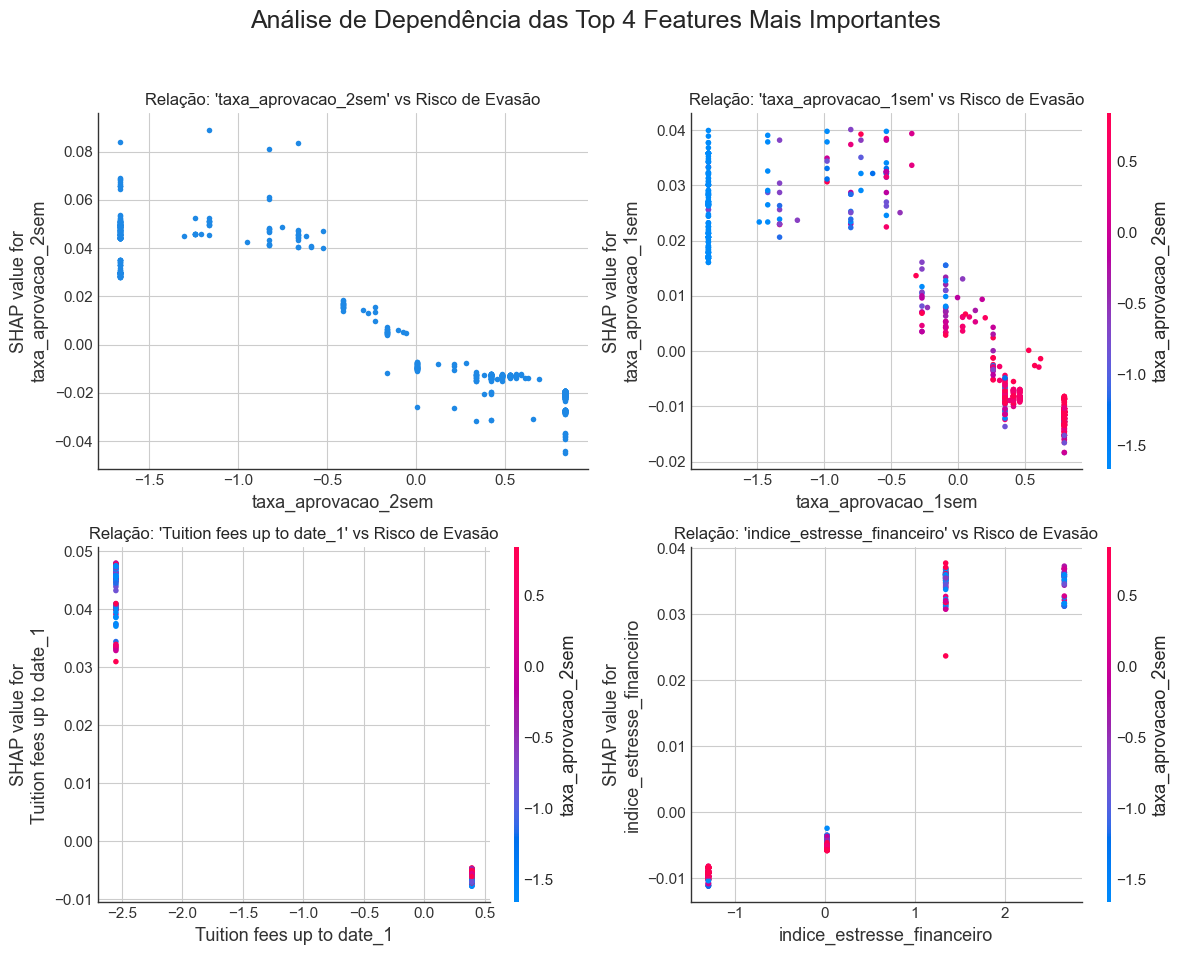

In [ ]:
mean_abs_shap = np.abs(shap_values.values[:, :, 1]).mean(0)
top_4_indices = np.argsort(mean_abs_shap)[-4:]
top_4_features = X_test_final.columns[top_4_indices][::-1]
main_interaction_feature = top_4_features[0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Dependence Analysis of the Top 4 Most Important Features', fontsize=18)

axes = axes.flatten()

for i, feature_name in enumerate(top_4_features):
    ax = axes[i]
    
    interaction_feature = main_interaction_feature if feature_name != main_interaction_feature else None
    
    shap.dependence_plot(
        feature_name,
        shap_values.values[:, :, 1],
        X_test_final,
        interaction_index=interaction_feature,
        ax=ax,
        show=False
    )
    ax.set_title(f"Relationship: '{feature_name}' vs Dropout Risk")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


1. **Relationship**: `taxa_aprovacao_2sem` vs Dropout Risk:

    - **Main Relationship**: This plot shows a clear and strong inverse relationship. As the pass rate in the 2nd semester (X-axis) increases, its impact on the prediction (Y-axis, the SHAP value) becomes increasingly negative. Students with low pass rates have positive SHAP values, strongly pushing them toward a `Dropout` prediction. Students with high pass rates have negative SHAP values, which "protect" them from dropout.
    - **Business Insight**: Recent academic performance is a critical and dynamic indicator. The model learned that a drop in 2nd semester performance is an immediate, high-impact warning sign.

2. **Relationship**: `taxa_aprovacao_1sem` vs Dropout Risk:

    - **Main Relationship**: The behavior is similar to the 2nd semester, validating that academic performance from the start of the course is fundamental. Low pass rates increase risk; high pass rates decrease it.
    - **Interaction Effect (Color)**: This plot is colored by `taxa_aprovacao_2sem`. Notice the vertical spread: for the same `taxa_aprovacao_1sem` value (a point on the X-axis), blue points (indicating low 2nd semester performance) consistently appear higher on the Y-axis than red points (high 2nd semester performance).
    - **Business Insight**: The model learned a crucial interaction: poor performance in the 1st semester is a risk factor, but it is an even greater risk factor if the student is also performing poorly in the 2nd semester. It identifies consistency or decline in performance as an aggravating factor.

3. **Relationship**: `Tuition fees up to date_1` vs Dropout Risk:

    - **Main Relationship**: Being a binary feature, the plot shows two distinct groups. On the X-axis, value `0` (overdue tuition) corresponds to positive SHAP values, increasing risk. Value `1` (tuition up to date) corresponds to negative SHAP values, acting as a strong protective factor.
    - **Interaction Effect (Color)**: Most points at `x=0` (overdue tuition) are blue, indicating these students also tend to have low `taxa_aprovacao_2sem`.
    - **Business Insight**: The model validated the strong connection between financial difficulty and academic difficulty. Being behind on tuition payments is not just an administrative issue but a strong indicator that the student may also be struggling academically.

4. **Relationship**: `indice_estresse_financeiro` vs Dropout Risk:

    - **Main Relationship**: Our engineered feature proves very powerful. We see three clear groups:
        - At value `-1` (likely a scholarship student with no debt), the impact is always protective (negative SHAP).
        - At value `0` (neutral financial situation), the impact is close to zero.
        - For values `≥1` (with debt and/or overdue tuition), the impact is always a risk factor (positive SHAP).
    - **Interaction Effect (Color)**: At high financial stress points (`x≥1`), blue points (low pass rate) have higher SHAP values than red points.
    - **Business Insight**: This is the most important conclusion. The model learned that the combination of high financial stress AND poor academic performance is the highest-risk scenario of all. It understands that these problems are not isolated but amplify each other.


## Why

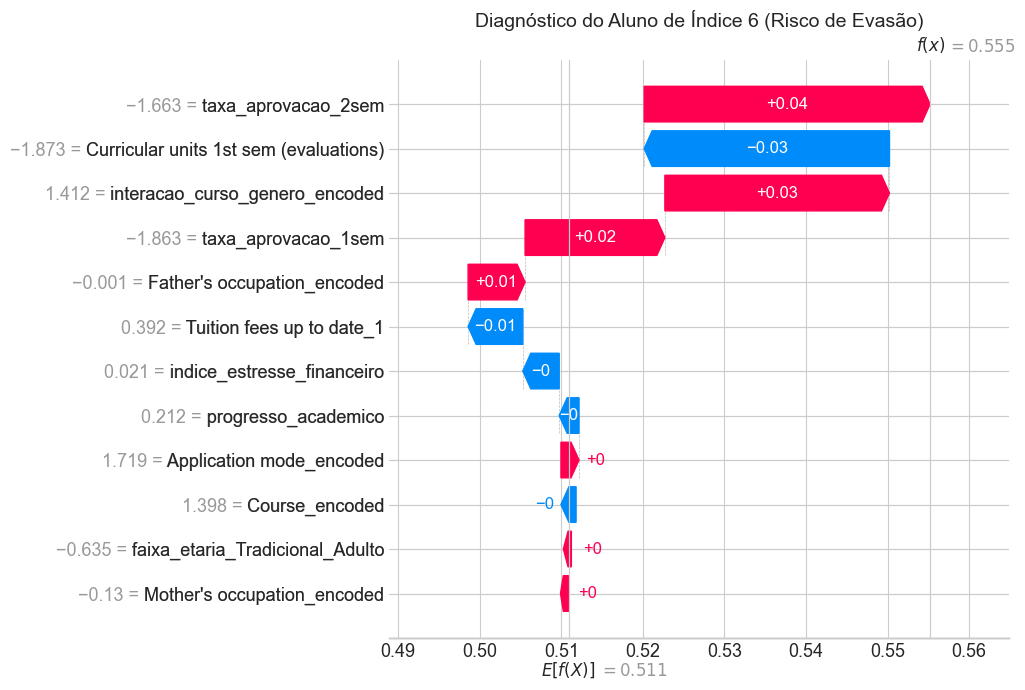

In [ ]:
y_pred_test = final_model.predict(X_test)
true_positives_indices = np.where((y_test == 1) & (y_pred_test == 1))[0]

if len(true_positives_indices) > 0:
    idx_to_explain = true_positives_indices[2]

    shap.waterfall_plot(shap_values[idx_to_explain, :, 1], max_display=20, show=False)
    plt.title(f"Student Diagnosis at Index {idx_to_explain} (Dropout Risk)", fontsize=14)
    plt.show()
else:
    print("No True Positive found in the sample to explain.")

The model’s prediction for this student does not start from zero. It begins from the base value (`E[f(x)] = 0.511`), which represents the average risk prediction for any student in the dataset. From there, each feature of Student 6 "pushes" this prediction up (increasing risk) or down (decreasing risk), until reaching the final result of `f(x) = 0.555`, which is a high value leading to a Dropout classification.

##### Risk Factors (Red bars pushing up):

The model flagged this student mainly due to very poor academic performance, evidenced by the three most impactful factors:

1. `taxa_aprovacao_2sem`: This was the feature with the largest negative impact. The extremely low pass rate in the second semester was the main factor increasing the dropout probability.
2. `interacao_curso_genero_encoded`: The student belongs to a course and gender combination which, based on historical data, has a high dropout tendency. This demographic profile alone was the second largest risk factor.
3. `taxa_aprovacao_1sem`: The low pass rate already in the first semester also contributed significantly to increasing risk, showing a pattern of difficulty from the start.

##### Protective Factors (Blue bars pushing down):

Conversely, some student characteristics acted to reduce risk, but were not strong enough:

1. `Curricular units 1st sem (evaluations)`: Interestingly, the number of evaluations in the first semester was the main protective factor for this student, pushing the prediction down. This may indicate that despite low achievement, the student was enrolled in fewer courses, which the model may have interpreted as a more manageable study load.
2. `Tuition fees up to date_1`: The fact that the student’s tuition payments were up to date also slightly helped reduce their risk.

# Conclusion

Student dropout represents one of the greatest financial and reputational losses for an educational institution. This project developed an artificial intelligence solution that transforms the institution's approach from reactive to **proactive**, enabling the identification of at-risk students with high precision before it is too late. Our analysis proves that focusing on the highest-risk students identified by the model is **more than 2.5 times more efficient** than any random outreach strategy, drastically optimizing the support team's resources.

The final result offers two operational strategies, each with a clear benefit:

- **The "Maximum Reach" Model (Uncalibrated)**: This implementation is a powerful "safety net," capable of correctly identifying **9 out of 10 students** who are on a dropout trajectory. Its financial value lies in **maximizing revenue recovery**, by offering the greatest possible opportunity to retain students who would otherwise be lost.

- **The "Smart Efficiency" Model (Calibrated)**: This implementation not only predicts but **quantifies risk with high confidence**. Its financial value lies in **optimizing the ROI (Return on Investment)** of retention actions. With reliable probabilities, the institution can create intervention programs with varying costs — for example, high-cost tutoring for students with >80% risk and low-cost follow-up for students with 60% risk — ensuring every invested dollar is allocated with maximum efficiency.

Regardless of the chosen strategy, the impact is clear. By successfully predicting and retaining even a small fraction of students who would drop out, the system generates a return that can **surpass the investment in its creation within a single semester**. This solution is not just a forecasting tool; it is a strategic asset that protects the institution’s most valuable resource — its students — and directly strengthens its financial sustainability and market reputation.